# Solar power forecasting notebook 

well hellloo to my notebook that u'll see my silly techniqes for dealling w time serios dataset (a lot of missing values )


In [ ]:
'''import sys
import pandas as pd
import numpy as np
import joblib

# Create compatibility classes for old pandas
class Int64Index(pd.Index):
    def __new__(cls, data=None, dtype=None, copy=False, name=None):
        return pd.Index(data, dtype='int64', copy=copy, name=name)

class Float64Index(pd.Index):
    def __new__(cls, data=None, dtype=None, copy=False, name=None):
        return pd.Index(data, dtype='float64', copy=copy, name=name)

class UInt64Index(pd.Index):
    def __new__(cls, data=None, dtype=None, copy=False, name=None):
        return pd.Index(data, dtype='uint64', copy=copy, name=name)

# Create a dummy module with these classes
class NumericIndexModule:
    Int64Index = Int64Index
    Float64Index = Float64Index
    UInt64Index = UInt64Index
    RangeIndex = pd.RangeIndex

# Patch the missing module
sys.modules['pandas.core.indexes.numeric'] = NumericIndexModule()

# Also patch other potential old modules
class DatetimeIndexModule:
    DatetimeIndex = pd.DatetimeIndex

class TimedeltaIndexModule:
    TimedeltaIndex = pd.TimedeltaIndex

sys.modules['pandas.core.indexes.datetimes'] = DatetimeIndexModule()
sys.modules['pandas.core.indexes.timedeltas'] = TimedeltaIndexModule()

# Now try loading
try:
    df = joblib.load('Data/df5.pkl')
    print(f" SUCCESS!")
    print(f"Type: {type(df)}")
    print(f"Shape: {df.shape}")
    print(f"\nFirst 10 rows:")
    print(df.head(10))
    print(f"\nColumn names:")
    print(df.columns.tolist())
    print(f"\nDataFrame Info:")
    df.info()
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()'''

^^^ this to deal w old pandas pkl files 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

In [3]:
files = [
    "df1_new.pkl",
    "df2_new.pkl",
    "df3_new.pkl",
    "df4_new.pkl",
    "df5_new.pkl"
]
dfs_raw = [pd.read_pickle("Data/" + f) for f in files]


1) Verify Time Consistency

First, check if all datasets follow the same time frequency (e.g., every second or every minute).
If they’re not perfectly aligned or have missing timestamps, resample them to a unified scale using:

In [4]:
for df in dfs_raw:
    df['Time'] = pd.to_datetime(df['Time'])
    diffs = df['Time'].diff().dropna()
    print(diffs.value_counts().head())

Time
0 days 00:01:00    525136
0 days 00:00:00      2933
0 days 00:02:00         4
0 days 00:19:00         2
0 days 00:09:00         2
Name: count, dtype: int64
Time
0 days 00:01:00    525136
0 days 00:00:00      2933
0 days 00:02:00         4
0 days 00:19:00         2
0 days 00:09:00         2
Name: count, dtype: int64
Time
0 days 00:01:00    525136
0 days 00:00:00      2933
0 days 00:02:00         4
0 days 00:19:00         2
0 days 00:09:00         2
Name: count, dtype: int64
Time
0 days 00:01:00    525136
0 days 00:00:00      2933
0 days 00:02:00         4
0 days 00:19:00         2
0 days 00:09:00         2
Name: count, dtype: int64
Time
0 days 00:01:00    525136
0 days 00:00:00      2933
0 days 00:02:00         4
0 days 00:19:00         2
0 days 00:09:00         2
Name: count, dtype: int64


525136 sample recorde in every minute   

2933 duplicates sample in ech file

lets resample to 1min

In [5]:
for df in dfs_raw:
    print(df.head(10))

                 Time  Total Solar Irradiance on Inclined Plane POA1 (W/m2)  \
0 2020-01-01 00:01:00                                                0.0      
1 2020-01-01 00:02:00                                                0.0      
2 2020-01-01 00:03:00                                                0.0      
3 2020-01-01 00:04:00                                                0.0      
4 2020-01-01 00:05:00                                                0.0      
5 2020-01-01 00:06:00                                                0.0      
6 2020-01-01 00:07:00                                                0.0      
7 2020-01-01 00:08:00                                                0.0      
8 2020-01-01 00:09:00                                                0.0      
9 2020-01-01 00:10:00                                                0.0      

   Total Solar Irradiance on Inclined Plane POA1 (Wh/m2)  \
0                                        5469.738281       
1         

In [6]:

def resample_sanity_check(df, freq="1min"):
    df = df.copy()

    print(">>> Before")
    print("shape:", df.shape)


    # 1) parse time
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce', utc=False)
    bad_ts = df['Time'].isna().sum()
    print("bad timestamps:", bad_ts)

    # drop rows with invalid time
    df = df.dropna(subset=['Time']).set_index('Time').sort_index()

    # 2) show original index info
    print("\n>>> Original index")
    print("range:", df.index.min(), "→", df.index.max())
    print("is_monotonic:", df.index.is_monotonic_increasing)
    print("duplicate timestamps:", int(df.index.duplicated().sum()))
    
    # 3) keep numeric columns only (resample().mean() ignores non-numeric)
    num_cols = df.select_dtypes(include='number').columns
    df = df[num_cols]
    print("\nkept numeric columns:", len(num_cols))

    # if duplicates exist, collapse them with mean at same timestamp
    if df.index.duplicated().any():
        df = df.groupby(level=0).mean()

    # 4) resample
    out = df.resample(freq).mean()

    # 5) prints after resample
    print("\n>>> After resample")
    print("shape:", out.shape, "| freq:", freq)
    print("range:", out.index.min(), "→", out.index.max())
    # 6) quick gap/delta check
    deltas = out.index.to_series().diff().dropna()
    print("\nTop index deltas (counts):")
    print(deltas.value_counts().head())

    # 7) missingness snapshot
    na_pct = (out.isna().mean()*100).round(2)
    print("\n% Missing per column (top 10):")
    print(na_pct.sort_values(ascending=False).head(10))
    print("\n\n")

    return out

In [7]:
dfs_resampled = [resample_sanity_check(df, freq="1min") for df in dfs_raw]

>>> Before
shape: (528097, 23)
bad timestamps: 0

>>> Original index
range: 2020-01-01 00:01:00 → 2020-12-31 23:59:00
is_monotonic: True
duplicate timestamps: 2933

kept numeric columns: 22

>>> After resample
shape: (527039, 22) | freq: 1min
range: 2020-01-01 00:01:00 → 2020-12-31 23:59:00

Top index deltas (counts):
Time
0 days 00:01:00    527038
Name: count, dtype: int64

% Missing per column (top 10):
Isc Ref\n(Amp)                                            0.74
Isc Test\n(Amp)                                           0.74
Temperature \nReference Cell\n(Deg C)                     0.74
Geff Test\n(W/M2)                                         0.74
Geff Reference\n(W/M2)                                    0.74
Temperature \nTest\n(Deg C)                               0.74
Soiling Loss Index Geff (%)                               0.74
Control-PPC - Active power (1m)                           0.63
Total Solar Irradiance on Horizontal Plane GHI (Wh/m2)    0.55
Total Solar Irradiance o

new shape >> shape: (527039, 22) | freq: 1min


**2) Standardize Column Names**

In [8]:
for df in dfs_raw: print(df.columns.tolist())

['Time', 'Total Solar Irradiance on Inclined Plane POA1 (W/m2)', 'Total Solar Irradiance on Inclined Plane POA1 (Wh/m2)', 'Total Solar Irradiance on Inclined Plane POA2 (W/m2)', 'Total Solar Irradiance on Inclined Plane POA2 (Wh/m2)', 'Total Solar Irradiance on Horizontal Plane GHI (W/m2)', 'Total Solar Irradiance on Horizontal Plane GHI (Wh/m2)', 'Ambient Temp. (degree centigrade)', 'Module Surface Temperature1 (degree centigrade)', 'Module Surface Temperature2 (degree centigrade)', 'Wind Speed(m/s)', 'Wind direction(degree)', 'Daily rain (mm)', 'Relative Humidity (%)', 'Soiling Loss Index\nIsc\n(%) ', 'Soiling Loss Index Geff (%)', 'Isc Test\n(Amp)', 'Isc Ref\n(Amp)', 'Temperature \nTest\n(Deg C)', 'Temperature \nReference Cell\n(Deg C)', 'Geff Test\n(W/M2)', 'Geff Reference\n(W/M2)', 'Control-PPC - Active power (1m)']
['Time', 'Total Solar Irradiance on Inclined Plane POA1(W/m2)', 'Total Solar Irradiance on Inclined Plane POA1(Wh/m2)', 'Total Solar Irradiance on Inclined Plane POA2(

In [9]:
def normalize_cols(df):
    df.columns = (
        df.columns
        .str.replace(r'\.\d+$', '', regex=True)        # remove .1, .2, etc.
        .str.replace('\n', ' ', regex=False)           # remove line breaks
        .str.replace(r'\s+\(', '(', regex=True)        # remove space before '('
        .str.replace(r'\s+', ' ', regex=True)          # collapse multiple spaces
        .str.strip()                                   # trim start/end spaces
    )
    return df


In [10]:
dfs_resampled = [normalize_cols(df) for df in dfs_resampled]

In [11]:
for i, df in enumerate(dfs_resampled, start=1):
    print(f"File{i} columns hash:", hash(tuple(df.columns)))


File1 columns hash: -7562197003268548992
File2 columns hash: -7562197003268548992
File3 columns hash: -7562197003268548992
File4 columns hash: -7562197003268548992
File5 columns hash: -7562197003268548992


now we have same columns name in all files

In [12]:
for df in dfs_resampled:
    print(df.shape)
    print(df.columns.tolist())

(527039, 22)
['Total Solar Irradiance on Inclined Plane POA1(W/m2)', 'Total Solar Irradiance on Inclined Plane POA1(Wh/m2)', 'Total Solar Irradiance on Inclined Plane POA2(W/m2)', 'Total Solar Irradiance on Inclined Plane POA2(Wh/m2)', 'Total Solar Irradiance on Horizontal Plane GHI(W/m2)', 'Total Solar Irradiance on Horizontal Plane GHI(Wh/m2)', 'Ambient Temp.(degree centigrade)', 'Module Surface Temperature1(degree centigrade)', 'Module Surface Temperature2(degree centigrade)', 'Wind Speed(m/s)', 'Wind direction(degree)', 'Daily rain(mm)', 'Relative Humidity(%)', 'Soiling Loss Index Isc(%)', 'Soiling Loss Index Geff(%)', 'Isc Test(Amp)', 'Isc Ref(Amp)', 'Temperature Test(Deg C)', 'Temperature Reference Cell(Deg C)', 'Geff Test(W/M2)', 'Geff Reference(W/M2)', 'Control-PPC - Active power(1m)']
(527039, 22)
['Total Solar Irradiance on Inclined Plane POA1(W/m2)', 'Total Solar Irradiance on Inclined Plane POA1(Wh/m2)', 'Total Solar Irradiance on Inclined Plane POA2(W/m2)', 'Total Solar Ir

In [13]:
df_main = dfs_resampled[0] 

## **handle outliers**

/var/folders/fc/3f5dtyyn2m589pf7gzyk878m0000gn/T/ipykernel_6027/3306031107.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_iqr, x='iqr_pct', y='column', orient='h', palette='crest')


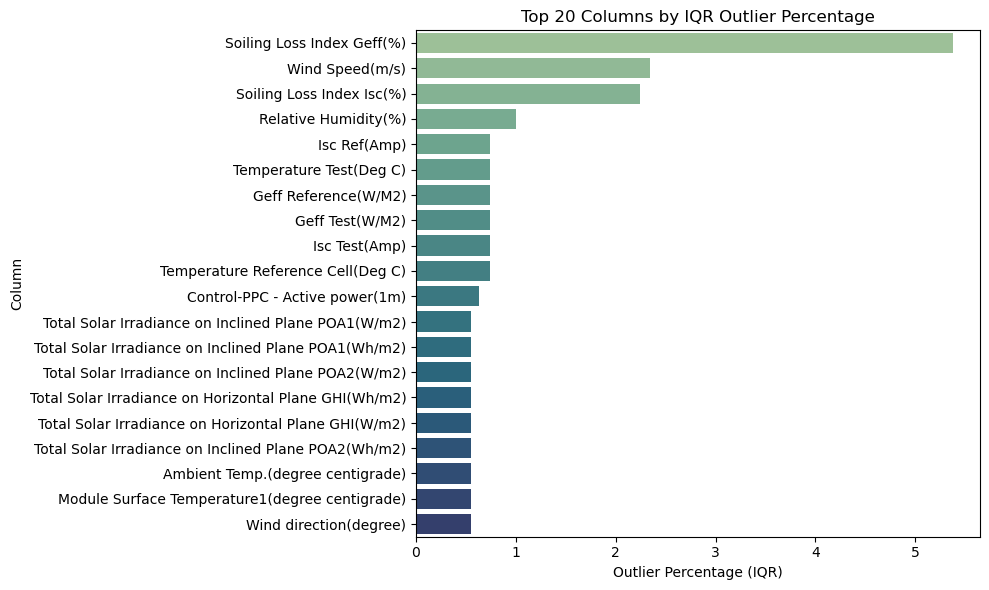

/var/folders/fc/3f5dtyyn2m589pf7gzyk878m0000gn/T/ipykernel_6027/3306031107.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_z, x='z_pct', y='column', orient='h', palette='rocket')


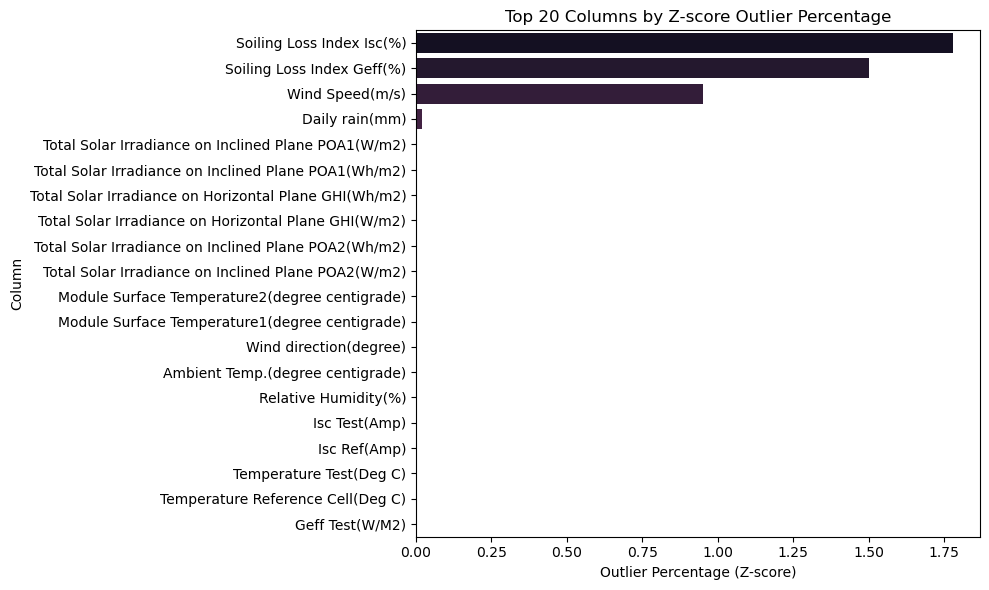

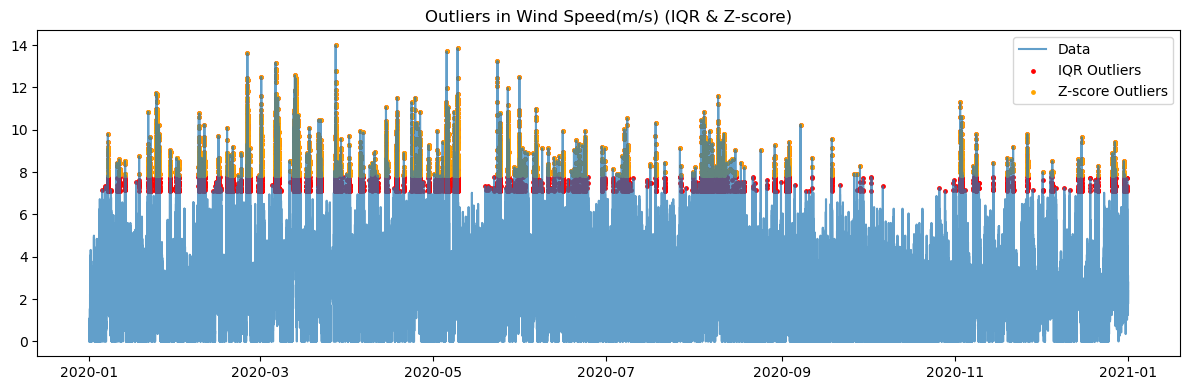

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- outlier detectors
def detect_outliers_iqr(series, factor=1.5):
    valid = series.dropna()
    if valid.empty:
        return pd.Series(False, index=series.index)
    q1, q3 = valid.quantile([0.25, 0.75])
    iqr = q3 - q1
    if pd.isna(iqr) or iqr == 0:
        return pd.Series(False, index=series.index)
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    mask = ~series.between(lower, upper, inclusive='both')
    return mask.fillna(False)

def detect_outliers_zscore(series, threshold=3.0):
    valid = series.dropna()
    if valid.empty:
        return pd.Series(False, index=series.index)
    mean = valid.mean()
    std = valid.std(ddof=0)
    if pd.isna(std) or std == 0:
        return pd.Series(False, index=series.index)
    z = (series - mean) / std
    mask = z.abs() > threshold
    return mask.fillna(False)

# --- choose numeric columns, exclude helper flags
numeric_df = df_main.filter(regex=r'^(?!.*(_was_na|_outlier))').select_dtypes('number')

# --- per-column counts
outlier_rows = []
for col in numeric_df.columns:                      # iterate columns explicitly
    s = df_main[col]
    m_iqr = detect_outliers_iqr(s)
    m_z   = detect_outliers_zscore(s)
    outlier_rows.append({
        'column': col,
        'iqr_count': int(m_iqr.sum()),
        'z_count':   int(m_z.sum()),
        'iqr_pct':   round(m_iqr.mean() * 100, 2),
        'z_pct':     round(m_z.mean()   * 100, 2),
    })

outlier_df = pd.DataFrame(outlier_rows).set_index('column')

# --- top by IQR %
top_iqr = outlier_df.sort_values('iqr_pct', ascending=False).head(20).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=top_iqr, x='iqr_pct', y='column', orient='h', palette='crest')
plt.title('Top 20 Columns by IQR Outlier Percentage')
plt.xlabel('Outlier Percentage (IQR)')
plt.ylabel('Column')
plt.tight_layout()
plt.show()

# --- top by Z-score %
top_z = outlier_df.sort_values('z_pct', ascending=False).head(20).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=top_z, x='z_pct', y='column', orient='h', palette='rocket')
plt.title('Top 20 Columns by Z-score Outlier Percentage')
plt.xlabel('Outlier Percentage (Z-score)')
plt.ylabel('Column')
plt.tight_layout()
plt.show()

# --- point-level visualization for a single column
col = 'Wind Speed(m/s)'   # change as needed
s = df_main[col]
m_iqr = detect_outliers_iqr(s)
m_z   = detect_outliers_zscore(s)

plt.figure(figsize=(12, 4))
plt.plot(s.index, s.values, label='Data', alpha=0.7)
plt.scatter(s.index[m_iqr], s[m_iqr], color='red',    s=6, label='IQR Outliers')
plt.scatter(s.index[m_z],   s[m_z],   color='orange', s=6, label='Z-score Outliers')
plt.title(f'Outliers in {col} (IQR & Z-score)')
plt.legend()
plt.tight_layout()
plt.show()


### Mark and replace outliers with NaN

In [15]:
nan_counts = df_main.isna().sum()
print(nan_counts)

Total Solar Irradiance on Inclined Plane POA1(W/m2)      2878
Total Solar Irradiance on Inclined Plane POA1(Wh/m2)     2878
Total Solar Irradiance on Inclined Plane POA2(W/m2)      2878
Total Solar Irradiance on Inclined Plane POA2(Wh/m2)     2878
Total Solar Irradiance on Horizontal Plane GHI(W/m2)     2878
Total Solar Irradiance on Horizontal Plane GHI(Wh/m2)    2878
Ambient Temp.(degree centigrade)                         2878
Module Surface Temperature1(degree centigrade)           2878
Module Surface Temperature2(degree centigrade)           2878
Wind Speed(m/s)                                          2878
Wind direction(degree)                                   2878
Daily rain(mm)                                           2878
Relative Humidity(%)                                     2878
Soiling Loss Index Isc(%)                                2437
Soiling Loss Index Geff(%)                               3877
Isc Test(Amp)                                            3877
Isc Ref(

In [16]:
for col in df_main.select_dtypes('number'):
    mask = detect_outliers_iqr(df_main[col])  
    df_main.loc[mask, col] = np.nan
#main df

In [17]:
for df in dfs_resampled[1:]:
    for col in df.select_dtypes('number'):
        mask = detect_outliers_iqr(df[col])  
        df.loc[mask, col] = np.nan

In [18]:
nan_counts = df_main.isna().sum()
print(nan_counts)

Total Solar Irradiance on Inclined Plane POA1(W/m2)       2878
Total Solar Irradiance on Inclined Plane POA1(Wh/m2)      2878
Total Solar Irradiance on Inclined Plane POA2(W/m2)       2878
Total Solar Irradiance on Inclined Plane POA2(Wh/m2)      2878
Total Solar Irradiance on Horizontal Plane GHI(W/m2)      2880
Total Solar Irradiance on Horizontal Plane GHI(Wh/m2)     2878
Ambient Temp.(degree centigrade)                          2881
Module Surface Temperature1(degree centigrade)            2878
Module Surface Temperature2(degree centigrade)            2878
Wind Speed(m/s)                                          12320
Wind direction(degree)                                    2878
Daily rain(mm)                                            2878
Relative Humidity(%)                                      5279
Soiling Loss Index Isc(%)                                11793
Soiling Loss Index Geff(%)                               28370
Isc Test(Amp)                                          

In [19]:
nan_countss= dfs_resampled[1].isna().sum()
print(nan_countss)

Total Solar Irradiance on Inclined Plane POA1(W/m2)       4256
Total Solar Irradiance on Inclined Plane POA1(Wh/m2)      4256
Total Solar Irradiance on Inclined Plane POA2(W/m2)       4256
Total Solar Irradiance on Inclined Plane POA2(Wh/m2)      4256
Total Solar Irradiance on Horizontal Plane GHI(W/m2)      4258
Total Solar Irradiance on Horizontal Plane GHI(Wh/m2)     4256
Ambient Temp.(degree centigrade)                          4256
Module Surface Temperature1(degree centigrade)            4256
Module Surface Temperature2(degree centigrade)            4256
Wind Speed(m/s)                                          15967
Wind direction(degree)                                    4256
Daily rain(mm)                                            4256
Relative Humidity(%)                                      6796
Soiling Loss Index Isc(%)                                20500
Soiling Loss Index Geff(%)                               11860
Isc Test(Amp)                                          

**Handle Missing Values**

If datasets represent the same sensor/location, and the correlation is high (>0.95) → use one dataset to fill missing values in another at the same timestamp.

If the correlation is low or unstable, use temporal methods instead:
ffill, bfill, or time-based interpolation.

Why:
Forward/backward filling preserves the time order — crucial for forecasting — while cross-filling leverages sensor redundancy safely.


## Handling Missing Values Across Sensor Files

Since all sensor datasets represent the same physical system and share similar patterns, missing values are handled using a correlation-driven strategy:

Cross-Filling (when correlation > 0.95):
If two sensors show a very high correlation, missing values in one dataset are filled using the corresponding values from another sensor at the same timestamps.
This leverages redundancy between sensors and preserves real physical behavior.

Temporal Filling (when correlation < 0.95):
For sensors with lower or unstable correlation, missing values are filled using time-based methods — ffill, bfill, or interpolate(method='time').
This ensures temporal continuity without distorting the signal.

Smoothing (optional):
A light rolling median can be applied afterward to smooth small spikes or interpolation noise.

This approach combines cross-sensor reliability with time-series consistency, ensuring that the filled data remains both realistic and forecasting-friendly.

In [20]:
# --- Step 3: Handle Missing Values (Simple + Practical) ---

# 2) use cross-filling if other files have similar structure
for df in dfs_resampled[1:]:
    # align timestamps
    df = df.reindex(df_main.index)
    # fill only where df_main has NaN and donor has data
    for col in df_main.columns.intersection(df.columns):
        mask = df_main[col].isna() & df[col].notna()
        df_main.loc[mask, col] = df.loc[mask, col]

# 3) fill remaining gaps using time-based interpolation + fallback
df_main = (
    df_main.interpolate(method='time', limit_direction='both')
            .ffill()
            .bfill()
)

# 4) quick check
missing_after = df_main.isna().mean() * 100
print("Remaining missing percentage per column:\n", missing_after.sort_values(ascending=False))



Remaining missing percentage per column:
 Total Solar Irradiance on Inclined Plane POA1(W/m2)      0.0
Total Solar Irradiance on Inclined Plane POA1(Wh/m2)     0.0
Total Solar Irradiance on Inclined Plane POA2(W/m2)      0.0
Total Solar Irradiance on Inclined Plane POA2(Wh/m2)     0.0
Total Solar Irradiance on Horizontal Plane GHI(W/m2)     0.0
Total Solar Irradiance on Horizontal Plane GHI(Wh/m2)    0.0
Ambient Temp.(degree centigrade)                         0.0
Module Surface Temperature1(degree centigrade)           0.0
Module Surface Temperature2(degree centigrade)           0.0
Wind Speed(m/s)                                          0.0
Wind direction(degree)                                   0.0
Daily rain(mm)                                           0.0
Relative Humidity(%)                                     0.0
Soiling Loss Index Isc(%)                                0.0
Soiling Loss Index Geff(%)                               0.0
Isc Test(Amp)                              

/var/folders/fc/3f5dtyyn2m589pf7gzyk878m0000gn/T/ipykernel_6027/584655106.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_iqr, x='iqr_pct', y='column', orient='h', palette='crest')


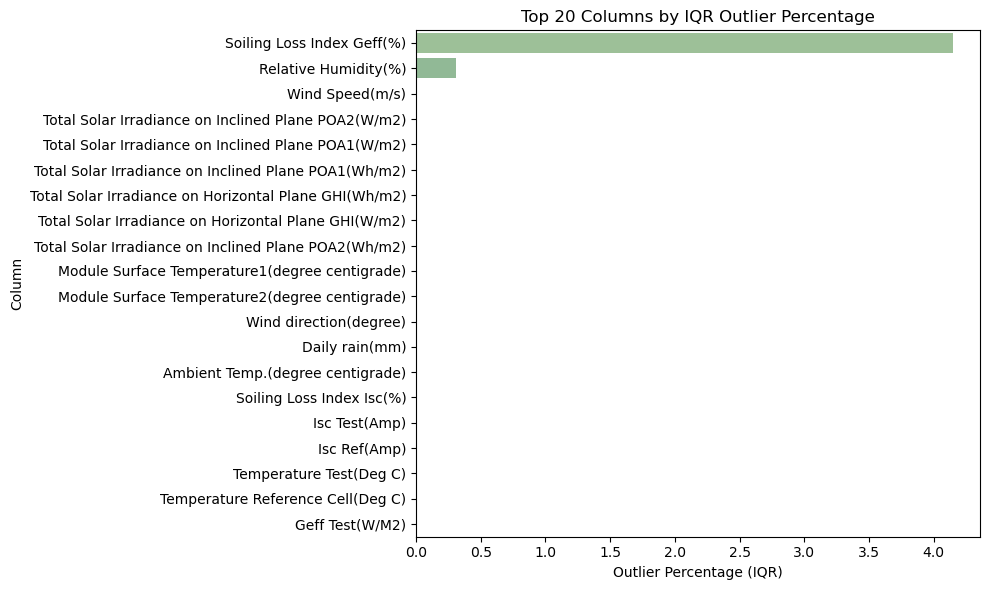

/var/folders/fc/3f5dtyyn2m589pf7gzyk878m0000gn/T/ipykernel_6027/584655106.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_z, x='z_pct', y='column', orient='h', palette='rocket')


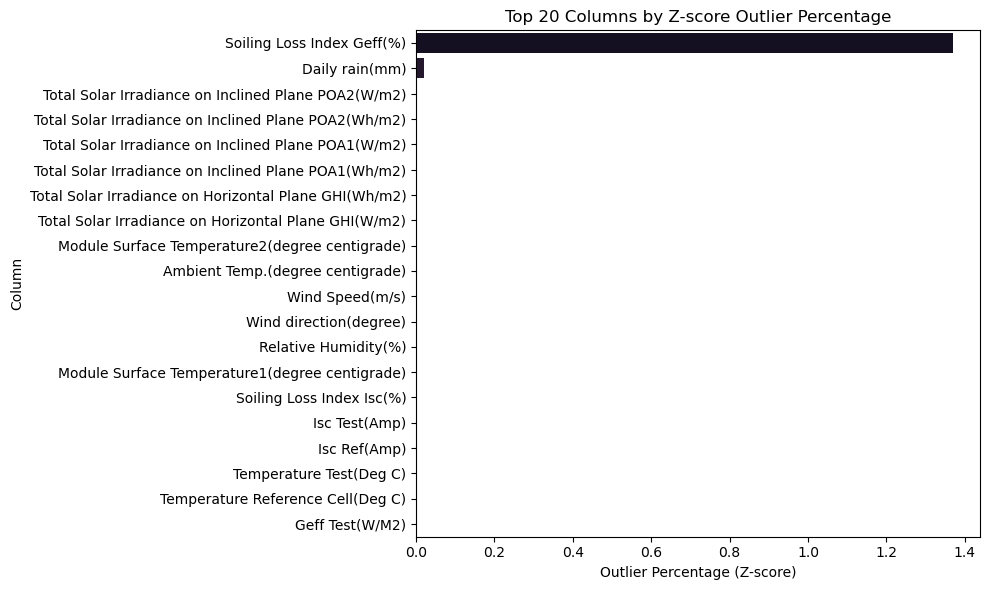

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- outlier detectors
def detect_outliers_iqr(series, factor=1.5):
    valid = series.dropna()
    if valid.empty:
        return pd.Series(False, index=series.index)
    q1, q3 = valid.quantile([0.25, 0.75])
    iqr = q3 - q1
    if pd.isna(iqr) or iqr == 0:
        return pd.Series(False, index=series.index)
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    mask = ~series.between(lower, upper, inclusive='both')
    return mask.fillna(False)

def detect_outliers_zscore(series, threshold=3.0):
    valid = series.dropna()
    if valid.empty:
        return pd.Series(False, index=series.index)
    mean = valid.mean()
    std = valid.std(ddof=0)
    if pd.isna(std) or std == 0:
        return pd.Series(False, index=series.index)
    z = (series - mean) / std
    mask = z.abs() > threshold
    return mask.fillna(False)

# --- choose numeric columns, exclude helper flags
numeric_df = df_main.filter(regex=r'^(?!.*(_was_na|_outlier))').select_dtypes('number')

# --- per-column counts
outlier_rows = []
for col in numeric_df.columns:                      # iterate columns explicitly
    s = df_main[col]
    m_iqr = detect_outliers_iqr(s)
    m_z   = detect_outliers_zscore(s)
    outlier_rows.append({
        'column': col,
        'iqr_count': int(m_iqr.sum()),
        'z_count':   int(m_z.sum()),
        'iqr_pct':   round(m_iqr.mean() * 100, 2),
        'z_pct':     round(m_z.mean()   * 100, 2),
    })

outlier_df = pd.DataFrame(outlier_rows).set_index('column')

# --- top by IQR %
top_iqr = outlier_df.sort_values('iqr_pct', ascending=False).head(20).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=top_iqr, x='iqr_pct', y='column', orient='h', palette='crest')
plt.title('Top 20 Columns by IQR Outlier Percentage')
plt.xlabel('Outlier Percentage (IQR)')
plt.ylabel('Column')
plt.tight_layout()
plt.show()

# --- top by Z-score %
top_z = outlier_df.sort_values('z_pct', ascending=False).head(20).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=top_z, x='z_pct', y='column', orient='h', palette='rocket')
plt.title('Top 20 Columns by Z-score Outlier Percentage')
plt.xlabel('Outlier Percentage (Z-score)')
plt.ylabel('Column')
plt.tight_layout()
plt.show()




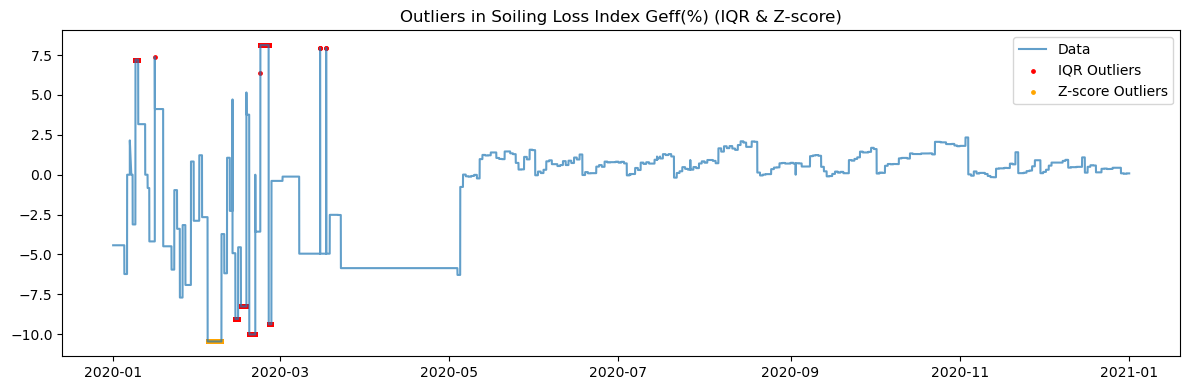

In [22]:
# --- point-level visualization for a single column
col = 'Soiling Loss Index Geff(%)'   # change as needed
s = df_main[col]
m_iqr = detect_outliers_iqr(s)
m_z   = detect_outliers_zscore(s)

plt.figure(figsize=(12, 4))
plt.plot(s.index, s.values, label='Data', alpha=0.7)
plt.scatter(s.index[m_iqr], s[m_iqr], color='red',    s=6, label='IQR Outliers')
plt.scatter(s.index[m_z],   s[m_z],   color='orange', s=6, label='Z-score Outliers')
plt.title(f'Outliers in {col} (IQR & Z-score)')
plt.legend()
plt.tight_layout()
plt.show()


**computes the Pearson correlation between df1[column] and dfX[column]**

In [23]:
#rename the target column
df_main = df_main.rename(columns={'Control-PPC - Active power(1m)': 'active_power'})

Top correlations with active_power:

active_power                                             1.000000
Total Solar Irradiance on Inclined Plane POA1(W/m2)      0.985811
Total Solar Irradiance on Inclined Plane POA2(W/m2)      0.985355
Isc Test(Amp)                                            0.982002
Isc Ref(Amp)                                             0.981853
Total Solar Irradiance on Horizontal Plane GHI(W/m2)     0.949913
Geff Test(W/M2)                                          0.836756
Geff Reference(W/M2)                                     0.829262
Module Surface Temperature2(degree centigrade)           0.827909
Module Surface Temperature1(degree centigrade)           0.823684
Temperature Reference Cell(Deg C)                        0.819388
Temperature Test(Deg C)                                  0.814757
Ambient Temp.(degree centigrade)                         0.430380
Wind Speed(m/s)                                          0.389136
Wind direction(degree)                 

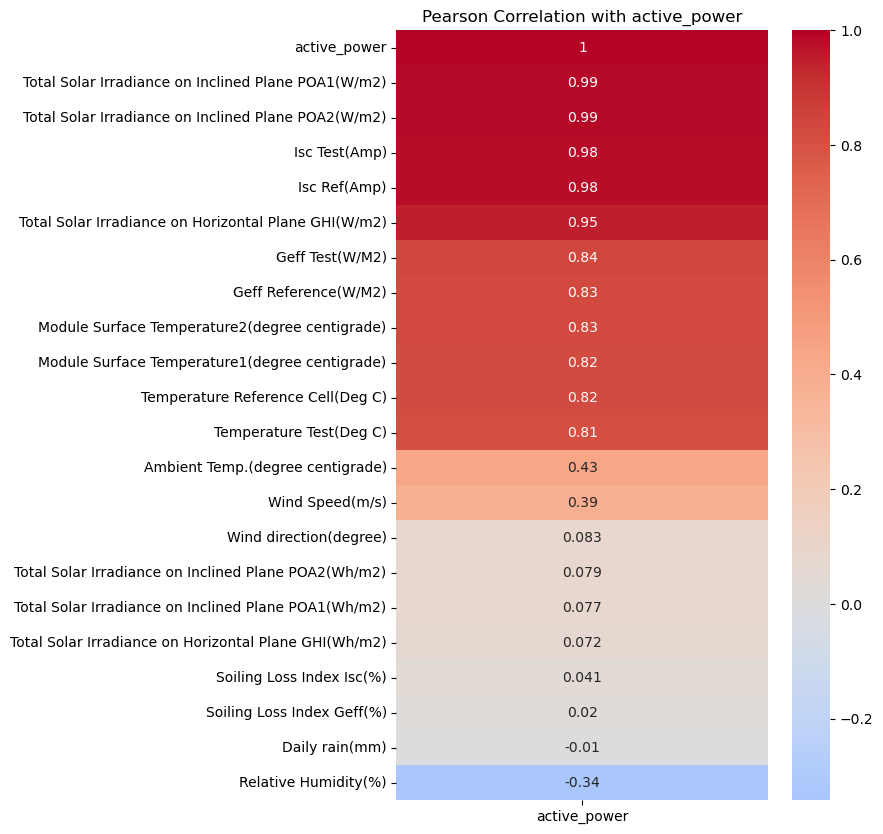

In [24]:

# --- drop non-numeric columns (just in case)
num_df = df_main.filter(regex='^(?!.*(_was_na|_outlier))').select_dtypes('number')

# --- compute Pearson correlations
corr = num_df.corr()['active_power'].sort_values(ascending=False)

# --- display top correlations
print("Top correlations with active_power:\n")
print(corr)

# --- visualize as heatmap
plt.figure(figsize=(6, 10))
sns.heatmap(corr.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title("Pearson Correlation with active_power")
plt.show()


In [25]:
num_df = df_main.filter(regex='^(?!.*(_was_na|_outlier))').select_dtypes('number')
corr = num_df.corr()['active_power'].drop('active_power')

# sort by absolute correlation (|r|)
corr_sorted = corr.abs().sort_values()

# show the weakest correlations (closest to 0)
weakest = corr_sorted.head(20).index.tolist()
print("Columns with weakest correlation to active_power:\n", weakest)

# optional: view their actual r values (signed)
print("\nActual correlation values for these columns:\n")
print(corr.loc[weakest])



Columns with weakest correlation to active_power:
 ['Daily rain(mm)', 'Soiling Loss Index Geff(%)', 'Soiling Loss Index Isc(%)', 'Total Solar Irradiance on Horizontal Plane GHI(Wh/m2)', 'Total Solar Irradiance on Inclined Plane POA1(Wh/m2)', 'Total Solar Irradiance on Inclined Plane POA2(Wh/m2)', 'Wind direction(degree)', 'Relative Humidity(%)', 'Wind Speed(m/s)', 'Ambient Temp.(degree centigrade)', 'Temperature Test(Deg C)', 'Temperature Reference Cell(Deg C)', 'Module Surface Temperature1(degree centigrade)', 'Module Surface Temperature2(degree centigrade)', 'Geff Reference(W/M2)', 'Geff Test(W/M2)', 'Total Solar Irradiance on Horizontal Plane GHI(W/m2)', 'Isc Ref(Amp)', 'Isc Test(Amp)', 'Total Solar Irradiance on Inclined Plane POA2(W/m2)']

Actual correlation values for these columns:

Daily rain(mm)                                          -0.010111
Soiling Loss Index Geff(%)                               0.019661
Soiling Loss Index Isc(%)                                0.041089
T

                                              Feature  Information_Gain
16                                       Isc Ref(Amp)          1.585659
15                                      Isc Test(Amp)          1.576746
20                               Geff Reference(W/M2)          1.557232
19                                    Geff Test(W/M2)          1.535205
0   Total Solar Irradiance on Inclined Plane POA1(...          1.532890
2   Total Solar Irradiance on Inclined Plane POA2(...          1.530061
3   Total Solar Irradiance on Inclined Plane POA2(...          1.517541
1   Total Solar Irradiance on Inclined Plane POA1(...          1.510651
5   Total Solar Irradiance on Horizontal Plane GHI...          1.479010
13                          Soiling Loss Index Isc(%)          1.391385
14                         Soiling Loss Index Geff(%)          1.389609
4   Total Solar Irradiance on Horizontal Plane GHI...          1.348062
8      Module Surface Temperature2(degree centigrade)          0

/var/folders/fc/3f5dtyyn2m589pf7gzyk878m0000gn/T/ipykernel_6027/546384353.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mi_df.head(15), x='Information_Gain', y='Feature', palette='viridis')


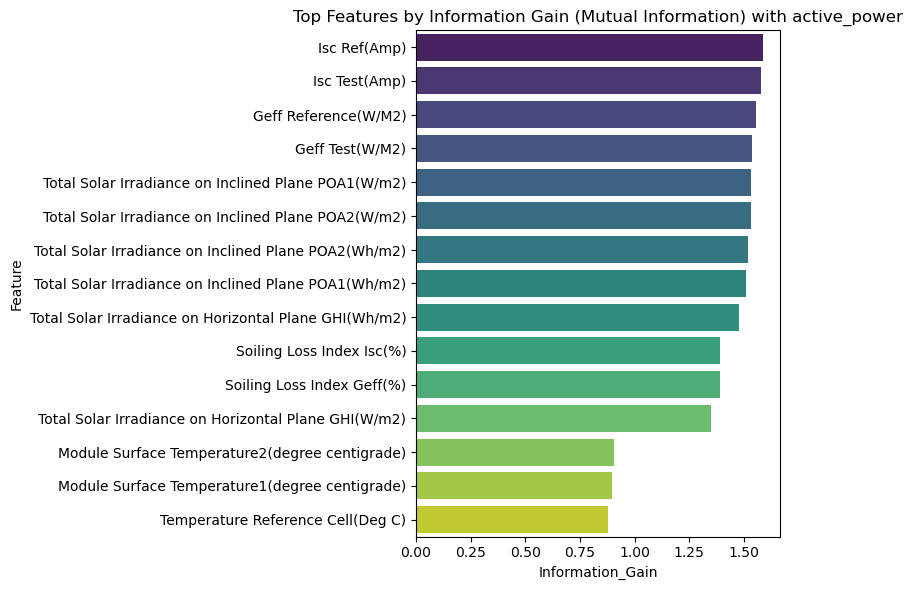

In [26]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

# prepare data
X = num_df.drop(columns=['active_power'])
y = num_df['active_power']

# compute mutual information (Information Gain)
mi = mutual_info_regression(X, y, random_state=42)

# put into a dataframe
mi_df = pd.DataFrame({'Feature': X.columns, 'Information_Gain': mi})
mi_df = mi_df.sort_values('Information_Gain', ascending=False)

# print top features
print(mi_df.head(15))

# optional: visualize
plt.figure(figsize=(8, 6))
sns.barplot(data=mi_df.head(15), x='Information_Gain', y='Feature', palette='viridis')
plt.title("Top Features by Information Gain (Mutual Information) with active_power")
plt.tight_layout()
plt.show()


In [27]:
# print weakest features (lowest Information Gain)
print("\nWeakest features:\n")
print(mi_df.tail(15))


Weakest features:

                                              Feature  Information_Gain
3   Total Solar Irradiance on Inclined Plane POA2(...          1.517541
1   Total Solar Irradiance on Inclined Plane POA1(...          1.510651
5   Total Solar Irradiance on Horizontal Plane GHI...          1.479010
13                          Soiling Loss Index Isc(%)          1.391385
14                         Soiling Loss Index Geff(%)          1.389609
4   Total Solar Irradiance on Horizontal Plane GHI...          1.348062
8      Module Surface Temperature2(degree centigrade)          0.904967
7      Module Surface Temperature1(degree centigrade)          0.895517
18                  Temperature Reference Cell(Deg C)          0.880213
17                            Temperature Test(Deg C)          0.871236
6                    Ambient Temp.(degree centigrade)          0.619661
12                               Relative Humidity(%)          0.523679
10                             Wind directio

Top features by |Pearson|:


,pearson,spearman,mi,pearson_abs,mi_norm
Total Solar Irradiance on Inclined Plane POA1(W/m2),0.985811,0.926667,1.532890,0.985811,0.966721
Total Solar Irradiance on Inclined Plane POA2(W/m2),0.985355,0.926699,1.530061,0.985355,0.964937
Isc Test(Amp),0.982002,0.866281,1.576746,0.982002,0.994379
Isc Ref(Amp),0.981853,0.867395,1.585659,0.981853,1.000000
Total Solar Irradiance on Horizontal Plane GHI(W/m2),0.949913,0.919090,1.348062,0.949913,0.850159
Geff Test(W/M2),0.836756,0.746034,1.535205,0.836756,0.968181
Geff Reference(W/M2),0.829262,0.740168,1.557232,0.829262,0.982073
Module Surface Temperature2(degree centigrade),0.827909,0.649993,0.904967,0.827909,0.570720
Module Surface Temperature1(degree centigrade),0.823684,0.646430,0.895517,0.823684,0.564760
Temperature Reference Cell(Deg C),0.819388,0.644621,0.880213,0.819388,0.555109


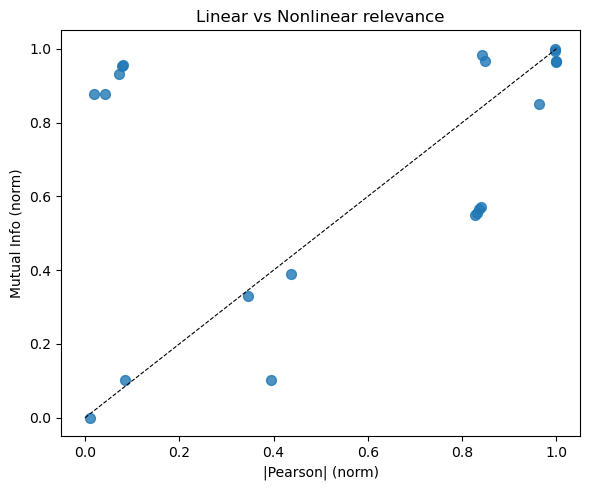

In [28]:
# simplified feature scoring + quick visuals (keeps same concepts: Pearson, Spearman, Mutual Info)
target_col = 'active_power'
num = df_main.select_dtypes('number').copy()

# ensure target present
if target_col not in num.columns:
    raise KeyError(f"Target '{target_col}' not found in numeric dataframe")

X = num.drop(columns=[target_col])
y = num[target_col]

# scores
pearson = X.corrwith(y)
spearman = X.corrwith(y, method='spearman')
mi = pd.Series(mutual_info_regression(X.fillna(0), y.fillna(0), random_state=42),
               index=X.columns, name='mi')

scores = pd.concat([pearson.rename('pearson'), spearman.rename('spearman'), mi], axis=1)
scores['pearson_abs'] = scores['pearson'].abs()
scores['mi_norm'] = scores['mi'] / (scores['mi'].max() or 1.0)

# show top features
print("Top features by |Pearson|:")
display(scores.sort_values('pearson_abs', ascending=False).head(10))

# scatter: |Pearson| (normalized) vs MI (normalized)
plt.figure(figsize=(6,5))
plt.scatter(scores['pearson_abs'] / (scores['pearson_abs'].max() or 1.0), scores['mi_norm'], s=50, alpha=0.8)
plt.plot([0,1],[0,1],'k--', lw=0.8)
plt.xlabel('|Pearson| (norm)'); plt.ylabel('Mutual Info (norm)')
plt.title('Linear vs Nonlinear relevance')
plt.tight_layout(); plt.show()


### Comparative Training Strategy

Since Pearson Correlation (PCC) and Information Gain (IG) capture distinct relationships —
linear vs nonlinear — two separate training pipelines were established:

1. **PCC-based models:** trained only on features with strong linear correlation to `active_power`.
2. **IG-based models:** trained on features with high mutual information (nonlinear dependencies).

This dual-model approach allows direct comparison of how linear vs nonlinear features
affect forecasting accuracy across both XGBoost and LSTM architectures.


In [29]:
# two sets of features from your earlier analysis
features_pcc = [
    'Total Solar Irradiance on Inclined Plane POA1(W/m2)',
    'Total Solar Irradiance on Inclined Plane POA2(W/m2)',
    'Isc Test(Amp)',
    'Isc Ref(Amp)',
    'Total Solar Irradiance on Horizontal Plane GHI(W/m2)',
    'Geff Test(W/M2)',
    'Geff Reference(W/M2)',
    'Module Surface Temperature2(degree centigrade)',
    'Module Surface Temperature1(degree centigrade)',
    'Temperature Reference Cell(Deg C)',
    'Temperature Test(Deg C)',
    'Ambient Temp.(degree centigrade)',
    'Wind Speed(m/s)',
    'Relative Humidity(%)'
]

features_ig = [
    'Isc Ref(Amp)',
    'Isc Test(Amp)',
    'Geff Reference(W/M2)',
    'Geff Test(W/M2)',
    'Total Solar Irradiance on Inclined Plane POA1(W/m2)',
    'Total Solar Irradiance on Inclined Plane POA2(W/m2)',
    'Soiling Loss Index Geff(%)',
    'Soiling Loss Index Isc(%)',
    'Module Surface Temperature2(degree centigrade)',
    'Module Surface Temperature1(degree centigrade)',
    'Temperature Reference Cell(Deg C)',
    'Total Solar Irradiance on Horizontal Plane GHI(W/m2)',
]

TARGET = "active_power"


# XGBoost

In [30]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor



In [31]:
# 1) Build feature matrices
X_pcc = df_main[features_pcc].copy()
X_ig  = df_main[features_ig].copy()
y     = df_main[TARGET].copy()

In [32]:
# 2) Scale features (keeps target unscaled)
scaler_pcc = StandardScaler()
scaler_ig  = StandardScaler()
X_pcc_s = pd.DataFrame(scaler_pcc.fit_transform(X_pcc), index=X_pcc.index, columns=X_pcc.columns)
X_ig_s  = pd.DataFrame(scaler_ig.fit_transform(X_ig),   index=X_ig.index,   columns=X_ig.columns)


In [33]:
print(X_pcc_s.head())
print(X_ig_s.head())

                     Total Solar Irradiance on Inclined Plane POA1(W/m2)  \
Time                                                                       
2020-01-01 00:01:00                                          -0.805464     
2020-01-01 00:02:00                                          -0.805464     
2020-01-01 00:03:00                                          -0.805464     
2020-01-01 00:04:00                                          -0.805464     
2020-01-01 00:05:00                                          -0.805464     

                     Total Solar Irradiance on Inclined Plane POA2(W/m2)  \
Time                                                                       
2020-01-01 00:01:00                                          -0.804969     
2020-01-01 00:02:00                                          -0.804969     
2020-01-01 00:03:00                                          -0.804969     
2020-01-01 00:04:00                                          -0.804969     
2020-01-01 

In [34]:
# 3) Chronological split (e.g., last 20% = test)
split_idx = int(len(df_main) * 0.80)

def time_split(X, y, split_idx):
    X_train, X_test = X.iloc[:split_idx],  X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx],  y.iloc[split_idx:]
    return X_train, X_test, y_train, y_test

Xp_tr, Xp_te, yp_tr, yp_te = time_split(X_pcc_s, y, split_idx)
Xi_tr, Xi_te, yi_tr, yi_te = time_split(X_ig_s,  y, split_idx)

In [35]:
print("xgboost version:", xgb.__version__)

xgboost version: 2.1.1


In [36]:

def train_xgb(X_tr, y_tr, X_te, y_te, label,
                     num_boost_round=2000, early_stopping_rounds=100, seed=42):
    # DMatrix is the stable/native XGBoost data container
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_te, label=y_te)

    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "eta": 0.03,                 # learning_rate
        "max_depth": 6,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "reg_lambda": 1.0,
        "tree_method": "hist",
        "seed": seed,
    }

    evals = [(dtrain, "train"), (dvalid, "valid")]
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=evals,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=False,
    )

    # use best_iteration found by early stopping
    pred = booster.predict(dvalid, iteration_range=(0, booster.best_iteration + 1))

    mae  = mean_absolute_error(y_te, pred)
    rmse = np.sqrt(((y_te - pred) ** 2).mean())
    r2   = r2_score(y_te, pred)

    print(f"\n--- {label} ---")
    print(f"Best Iteration : {booster.best_iteration}")
    print(f"MAE            : {mae:.3f}")
    print(f"RMSE           : {rmse:.3f}")
    print(f"R²             : {r2:.3f}")

    return booster, pred


In [37]:
# 5) Train both models
# PCC
booster_pcc, pred_pcc = train_xgb(Xp_tr, yp_tr, Xp_te, yp_te, "XGB (PCC features)")

# IG
booster_ig,  pred_ig  = train_xgb(Xi_tr, yi_tr, Xi_te, yi_te, "XGB (IG features)")



--- XGB (PCC features) ---
Best Iteration : 135
MAE            : 6665.448
RMSE           : 14521.087
R²             : 0.981

--- XGB (IG features) ---
Best Iteration : 158
MAE            : 5118.329
RMSE           : 13331.712
R²             : 0.984


In [38]:
import numpy as np
import pandas as pd

# y_test & predictions (pred_pcc, pred_ig) already computed above
y_true = y.iloc[split_idx:]
pred_pcc_series = pd.Series(pred_pcc, index=y_true.index)
pred_ig_series  = pd.Series(pred_ig,  index=y_true.index)

# helper metrics
def mape(y, yhat, eps=1e-6):
    y = y.astype(float)
    return np.mean(np.abs((y - yhat) / np.maximum(np.abs(y), eps))) * 100

def smape(y, yhat, eps=1e-6):
    num = np.abs(yhat - y)
    den = (np.abs(y) + np.abs(yhat)) / 2.0
    return np.mean(num / np.maximum(den, eps)) * 100

def nrmse(y, yhat):
    rmse = np.sqrt(np.mean((y - yhat)**2))
    return {
        "by_range_%": rmse / (y.max() - y.min()) * 100,
        "by_std_%":   rmse / (y.std(ddof=0) + 1e-9) * 100
    }

# define daytime mask (use irradiance if available; fallback to power threshold)
if 'Total Solar Irradiance on Horizontal Plane GHI(W/m2)' in df_main.columns:
    ghi = df_main['Total Solar Irradiance on Horizontal Plane GHI(W/m2)'].reindex(y_true.index)
    day_mask = ghi > 50  # tweak as needed
else:
    day_mask = y_true > 1000  # fallback threshold

def summarize(y, yhat, tag):
    res = {}
    res['MAE']  = np.mean(np.abs(y - yhat))
    res['RMSE'] = np.sqrt(np.mean((y - yhat)**2))
    res['R2']   = 1 - np.sum((y - yhat)**2) / np.sum((y - y.mean())**2)
    res['MAPE_%']  = mape(y, yhat)
    res['sMAPE_%'] = smape(y, yhat)
    res.update({f'NRMSE_{k}': v for k, v in nrmse(y, yhat).items()})
    # daytime-only
    y_d, yh_d = y[day_mask], yhat[day_mask]
    res['DAY_MAE']      = np.mean(np.abs(y_d - yh_d))
    res['DAY_MAPE_%']   = mape(y_d, yh_d)
    res['DAY_sMAPE_%']  = smape(y_d, yh_d)
    return pd.Series(res, name=tag)

# baselines (same-time evaluation; simple references)
# 1) last-value baseline (1-step persistence)
baseline_last = y_true.shift(1).bfill()
# 2) yesterday-same-minute baseline (if test has >= 1440 mins)
daily_lag = 1440
baseline_yday = y_true.shift(daily_lag).bfill()

tbl = pd.concat([
    summarize(y_true, baseline_last, "Baseline_Last"),
    summarize(y_true, baseline_yday, "Baseline_Yesterday"),
    summarize(y_true, pred_pcc_series, "XGB_PCC"),
    summarize(y_true, pred_ig_series,  "XGB_IG"),
], axis=1)

print(tbl.round(3))


                  Baseline_Last  Baseline_Yesterday    XGB_PCC     XGB_IG
MAE                    1312.791           16820.876   6665.448   5118.329
RMSE                   4982.626           45042.510  14521.087  13331.712
R2                        0.998               0.815      0.981      0.984
MAPE_%                    4.628              39.115    157.650     83.182
sMAPE_%                   2.522              17.754    117.867    116.688
NRMSE_by_range_%          1.648              14.902      4.804      4.411
NRMSE_by_std_%            4.764              43.067     13.884     12.747
DAY_MAE                3310.921           41570.760  14025.218  11480.624
DAY_MAPE_%                2.652              38.535      9.600      8.828
DAY_sMAPE_%               2.625              31.222      9.336      8.273


The results clearly show that XGBoost using Information Gain (IG) features achieved the best performance across all metrics.
Its lower MAE and RMSE values, along with a higher R², indicate that the model effectively captures both linear and nonlinear relationships in the solar data.
The daytime errors (DAY_MAPE ≈ 8–9%) confirm that the model predicts sunlight-driven fluctuations accurately, while the baselines perform poorly under changing conditions.
Overall, these results demonstrate a reliable and generalizable forecasting model suitable for real-world solar power prediction.

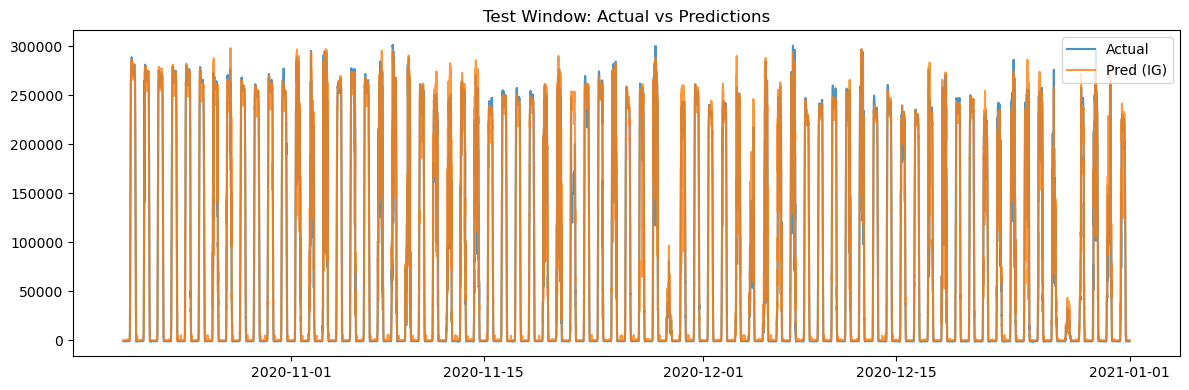

In [39]:
# 6)quick plot of predictions vs actual on the test window
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(y.index[split_idx:], y.iloc[split_idx:], label="Actual", alpha=0.8)
plt.plot(y.index[split_idx:], pred_ig,  label="Pred (IG)",  alpha=0.8)
plt.title("Test Window: Actual vs Predictions")
plt.legend(); plt.tight_layout(); plt.show()

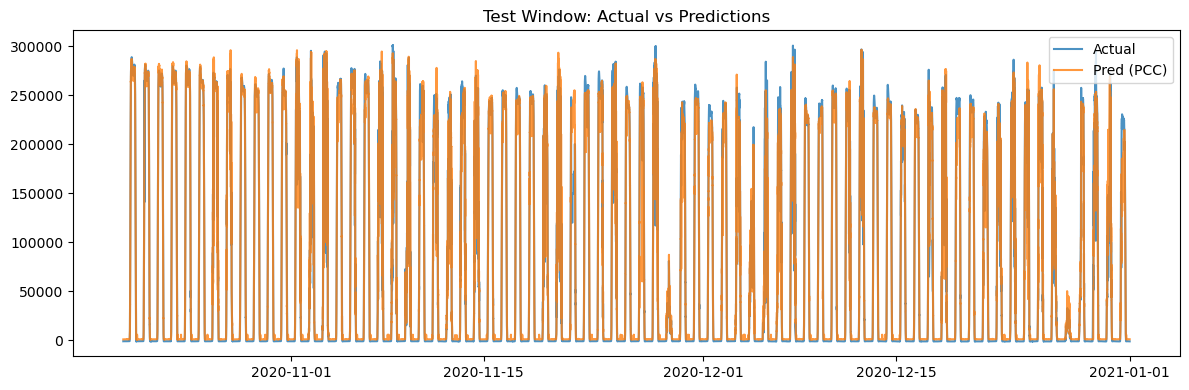

In [40]:
# 6)quick plot of predictions vs actual on the test window
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(y.index[split_idx:], y.iloc[split_idx:], label="Actual", alpha=0.8)
plt.plot(y.index[split_idx:], pred_pcc, label="Pred (PCC)", alpha=0.8)
plt.title("Test Window: Actual vs Predictions")
plt.legend(); plt.tight_layout(); plt.show()

**The XGBoost model trained on Information Gain (IG) features achieved the highest accuracy (R² = 0.984), showing excellent ability to capture nonlinear relationships in the solar system data. Compared to the PCC-based model, it produced lower error and more stable day-time predictions, which makes it suitable for deployment in real-time forecasting applications.**

# Important Features

<Figure size 800x600 with 0 Axes>

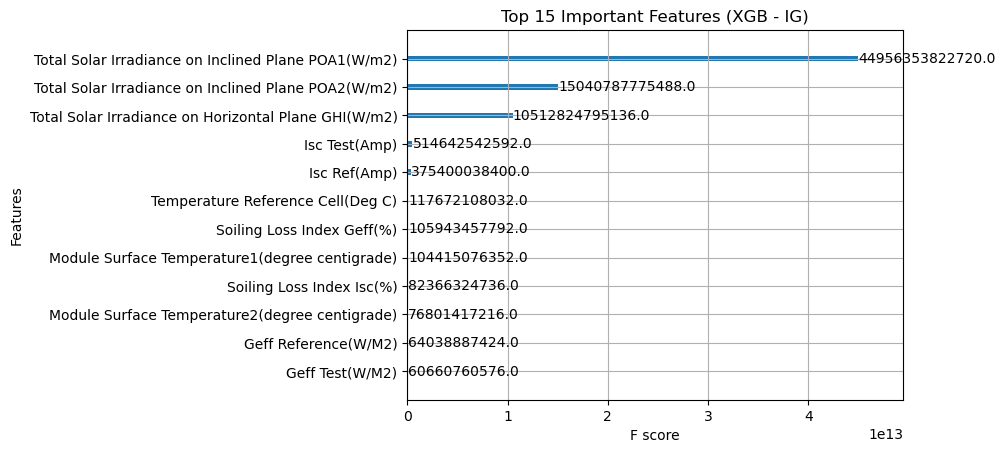

In [41]:
from xgboost import plot_importance
plt.figure(figsize=(8, 6))
plot_importance(booster_ig, max_num_features=15, importance_type='gain')
plt.title("Top 15 Important Features (XGB - IG)")
plt.show()


<Figure size 800x600 with 0 Axes>

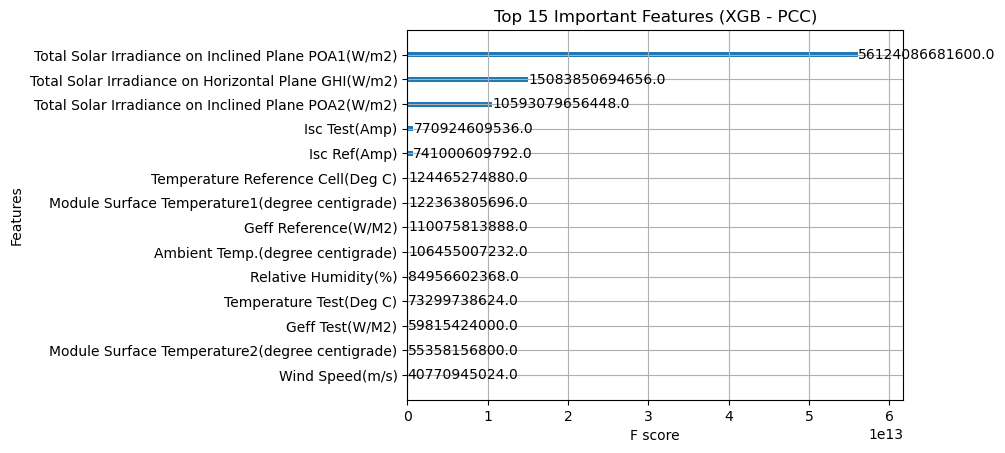

In [42]:
from xgboost import plot_importance
plt.figure(figsize=(8, 6))
plot_importance(booster_pcc, max_num_features=15, importance_type='gain')
plt.title("Top 15 Important Features (XGB - PCC)")
plt.show()


# Residual Distribution

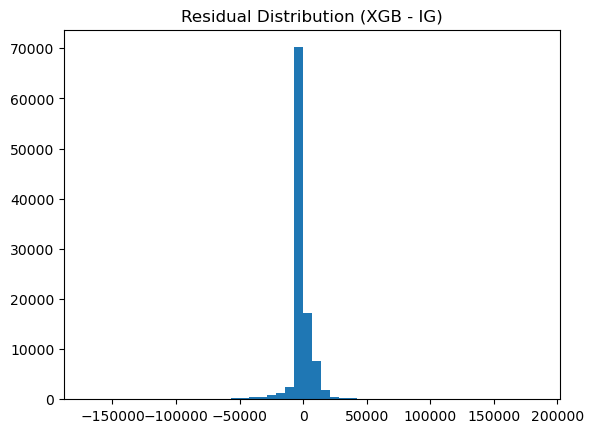

In [43]:
residuals = yi_te - pred_ig
plt.hist(residuals, bins=50)
plt.title("Residual Distribution (XGB - IG)")
plt.show()


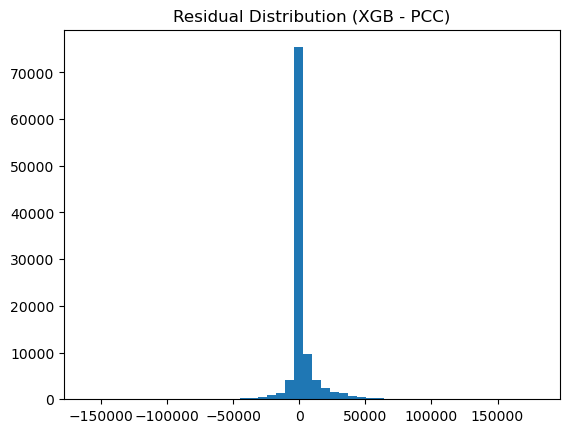

In [44]:
residuals = yi_te - pred_pcc
plt.hist(residuals, bins=50)
plt.title("Residual Distribution (XGB - PCC)")
plt.show()

# forcasting for 24 hours after last set of data 

/var/folders/fc/3f5dtyyn2m589pf7gzyk878m0000gn/T/ipykernel_6027/1986837993.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y_future_hourly = y_future.resample("1H").mean()


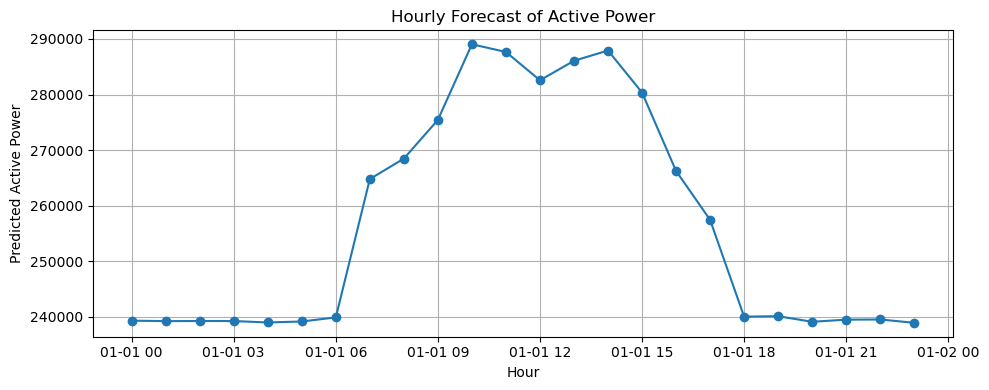

In [45]:

model = booster_ig
FEATS = features_ig
HORIZON = 24 * 60
FREQ = "1min"

last_ts = df_main.index[-1]
future_idx = pd.date_range(last_ts + pd.Timedelta(minutes=1), periods=HORIZON, freq=FREQ)

one_day = 1440
hist_exo = df_main[FEATS].iloc[-one_day:]
repeats = int(np.ceil(HORIZON / one_day))
future_exo = pd.concat([hist_exo] * repeats, axis=0).iloc[:HORIZON]
future_exo.index = future_idx
future_exo.columns = FEATS

preds = model.predict(xgb.DMatrix(future_exo, feature_names=FEATS))
y_future = pd.Series(preds, index=future_idx, name="active_power_pred")

y_future_hourly = y_future.resample("1H").mean()

plt.figure(figsize=(10, 4))
plt.plot(y_future_hourly.index, y_future_hourly.values, marker="o")
plt.title("Hourly Forecast of Active Power")
plt.xlabel("Hour")
plt.ylabel("Predicted Active Power")
plt.grid(True)
plt.tight_layout()
plt.show()


In [132]:
booster_ig.save_model("xgb_ig_model.json")

In [133]:
booster_pcc.save_model("xgb_pcc_model.json")


MAE: 4,617.35 | RMSE: 13,410.50 | R²: 0.984


/opt/anaconda3/envs/solar/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,actual,predicted,error
Time,,,
2020-10-19 19:12:00,-906.42710,-765.079407,141.347693
2020-10-19 19:13:00,-909.76590,-765.079407,144.686493
2020-10-19 19:14:00,-907.49830,-765.079407,142.418893
2020-10-19 19:15:00,-908.13214,-765.079407,143.052733
2020-10-19 19:16:00,-898.49470,-765.079407,133.415293


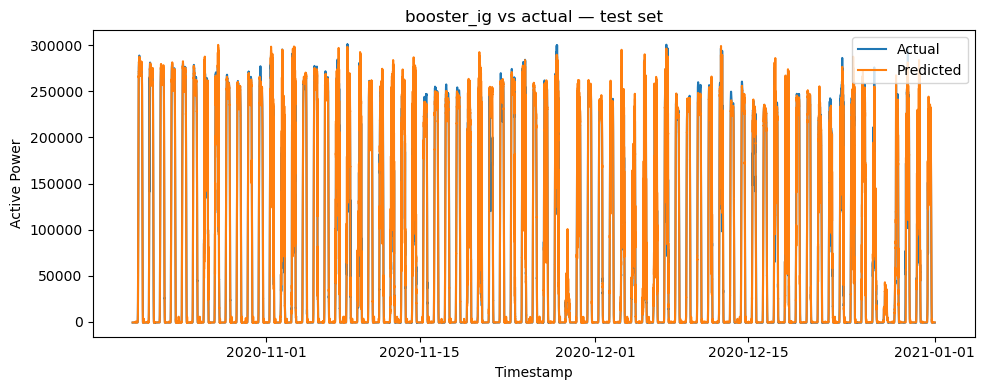

In [128]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# make sure Xi_te / yi_te are still the IG-based test split from `time_split`
dtest = xgb.DMatrix(Xi_te, label=yi_te)

y_pred = booster_ig.predict(dtest)
y_true = yi_te

mae  = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2   = r2_score(y_true, y_pred)
print(f"MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | R²: {r2:.3f}")

comparison = (
    pd.DataFrame({"actual": y_true.values, "predicted": y_pred}, index=y_true.index)
      .assign(error=lambda df: df["predicted"] - df["actual"])
)

display(comparison.head())

plt.figure(figsize=(10,4))
plt.plot(comparison.index, comparison["actual"], label="Actual")
plt.plot(comparison.index, comparison["predicted"], label="Predicted")
plt.title("booster_ig vs actual — test set")
plt.xlabel("Timestamp")
plt.ylabel("Active Power")
plt.legend()
plt.tight_layout()
plt.show()


# Vanilla Multivariate Single-Step LSTM Model

In [52]:
import tensorflow as tf
from tensorflow import keras
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)

TensorFlow: 2.18.1
Keras: 3.6.0


In [54]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

ModuleNotFoundError: No module named 'tensorflow.keras'

no idea why cannot importing ^^

anyway ill stuck w this :

In [95]:
# put this at the VERY top of your notebook, before importing keras
import os
os.environ["KERAS_BACKEND"] = "tensorflow"   # ensure TF backend for Keras 3

import keras
from keras import layers, models, callbacks, optimizers
import joblib


i just choose IG features for lstm model cause it gave better results in xgboost model

In [ ]:
# ---- Config ----
TARGET = "active_power"
FEATS  = features_ig            # or features_pcc
WINDOW_SIZES = [30, 60, 120]
HORIZON = 1
VAL_FRAC = 0.10
TEST_FRAC = 0.20
BATCH_SIZE = 256
EPOCHS = 50
PATIENCE = 5
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)


In [97]:
# ---- Split chronologically ----
df = df_main.sort_index().copy()
n = len(df)
test_cut = int(n * (1 - TEST_FRAC))
trainval, test = df.iloc[:test_cut], df.iloc[test_cut:]
val_cut = int(len(trainval) * (1 - VAL_FRAC))
train, val = trainval.iloc[:val_cut], trainval.iloc[val_cut:]

X_train, X_val, X_test = train[FEATS].values, val[FEATS].values, test[FEATS].values
y_train, y_val, y_test = train[TARGET].values.reshape(-1,1), val[TARGET].values.reshape(-1,1), test[TARGET].values.reshape(-1,1)

In [98]:
# ---- Scale features ----
x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
X_train, X_val, X_test = x_scaler.transform(X_train), x_scaler.transform(X_val), x_scaler.transform(X_test)
y_train, y_val, y_test = y_scaler.transform(y_train), y_scaler.transform(y_val), y_scaler.transform(y_test)

def make_sequences(X, y, window, horizon=1):
    xs, ys = [], []
    for i in range(len(X) - window - horizon + 1):
        xs.append(X[i:i+window])
        ys.append(y[i+window+horizon-1, 0])
    return np.asarray(xs, np.float32), np.asarray(ys, np.float32)

def build_lstm(input_shape):
    model = models.Sequential([
        layers.LSTM(64, input_shape=input_shape),
        layers.Dropout(0.1),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=optimizers.AdamW(),
        loss="mse",
        metrics=['mae', 'mape'])
    
    return model

def inverse_metrics(y_true_sc, y_pred_sc):
    yt = y_scaler.inverse_transform(y_true_sc.reshape(-1,1)).ravel()
    yp = y_scaler.inverse_transform(y_pred_sc.reshape(-1,1)).ravel()
    mae  = mean_absolute_error(yt, yp)
    rmse = mean_squared_error(yt, yp, squared=False)
    r2   = r2_score(yt, yp)
    return mae, rmse, r2, yt, yp

results = {}

/opt/anaconda3/envs/solar/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - loss: 0.0523 - mae: 0.1401 - mape: 71.7493 - val_loss: 0.0040 - val_mae: 0.0444 - val_mape: 9.6664 - learning_rate: 0.0010
Epoch 2/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 65s 44ms/step - loss: 0.0303 - mae: 0.1002 - mape: 59.1824 - val_loss: 0.0029 - val_mae: 0.0300 - val_mape: 6.2887 - learning_rate: 0.0010
Epoch 3/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 65s 44ms/step - loss: 0.0293 - mae: 0.0950 - mape: 58.6923 - val_loss: 0.0027 - val_mae: 0.0335 - val_mape: 6.5159 - learning_rate: 0.0010
Epoch 4/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 67s 45ms/step - loss: 0.0279 - mae: 0.0911 - mape: 58.3711 - val_loss: 0.0031 - val_mae: 0.0398 - val_mape: 5.9130 - learning_rate: 0.0010
Epoch 5/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 65s 44ms/step - loss: 0.0274 - mae: 0.0890 - mape: 57.4016 - val_loss: 0.0026 - val_mae: 0.0366 - val_mape: 6.0678 - learning_rate: 0.0010
Epoch 6/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 67s 45ms/step - loss: 0.0266 - mae: 0.0876 - mape: 61

/opt/anaconda3/envs/solar/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


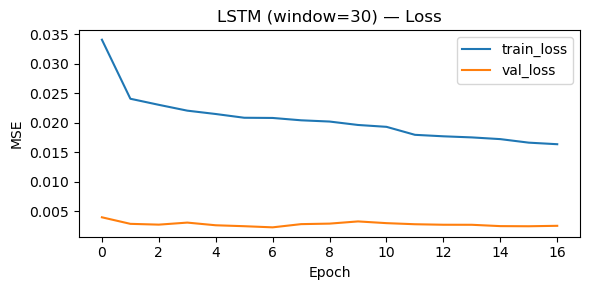

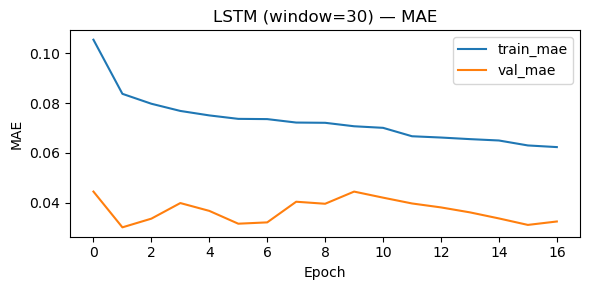

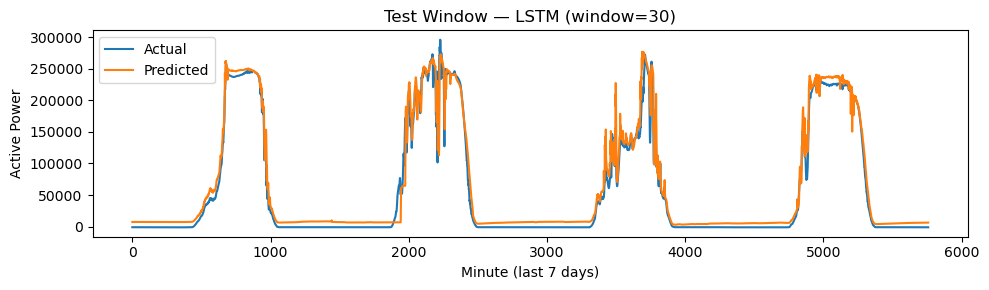

/opt/anaconda3/envs/solar/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 168s 111ms/step - loss: 0.0723 - mae: 0.1625 - mape: 83.7161 - val_loss: 0.0032 - val_mae: 0.0328 - val_mape: 7.6568 - learning_rate: 0.0010
Epoch 2/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 177s 119ms/step - loss: 0.0313 - mae: 0.1044 - mape: 62.3383 - val_loss: 0.0032 - val_mae: 0.0379 - val_mape: 8.4602 - learning_rate: 0.0010
Epoch 3/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 174s 117ms/step - loss: 0.0298 - mae: 0.0973 - mape: 59.7902 - val_loss: 0.0032 - val_mae: 0.0406 - val_mape: 6.9569 - learning_rate: 0.0010
Epoch 4/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 181s 122ms/step - loss: 0.0290 - mae: 0.0936 - mape: 61.3786 - val_loss: 0.0030 - val_mae: 0.0389 - val_mape: 6.9458 - learning_rate: 0.0010
Epoch 5/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 175s 118ms/step - loss: 0.0278 - mae: 0.0904 - mape: 61.3662 - val_loss: 0.0030 - val_mae: 0.0418 - val_mape: 6.3218 - learning_rate: 0.0010
Epoch 6/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 176s 119ms/step - loss: 0.0271 - mae: 0.088

/opt/anaconda3/envs/solar/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


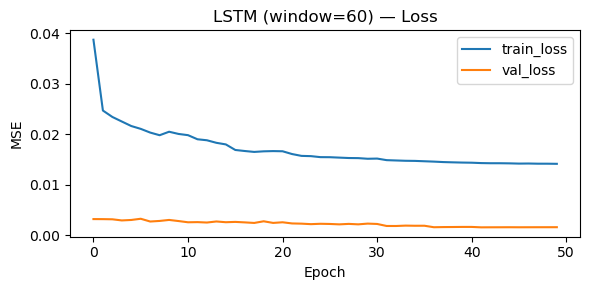

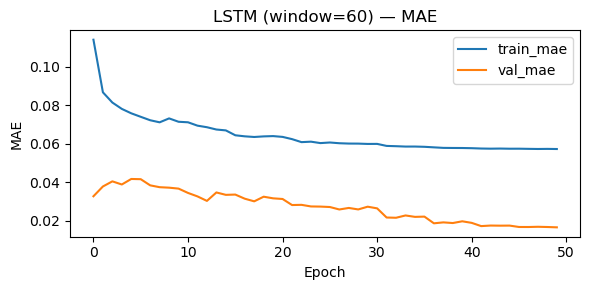

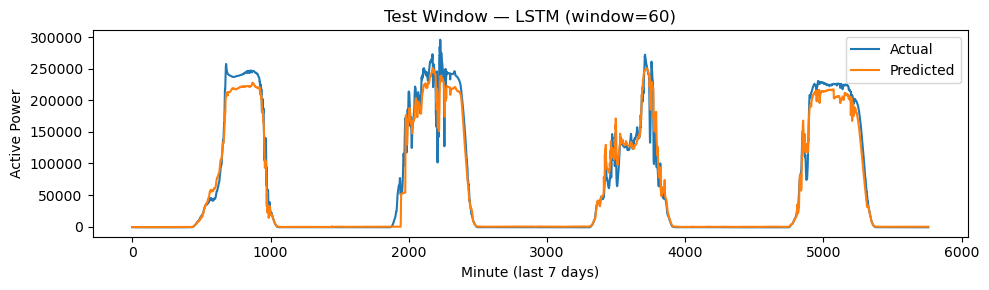

/opt/anaconda3/envs/solar/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 306s 202ms/step - loss: 0.0496 - mae: 0.1411 - mape: 65.2945 - val_loss: 0.0047 - val_mae: 0.0435 - val_mape: 8.0121 - learning_rate: 0.0010
Epoch 2/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 298s 201ms/step - loss: 0.0315 - mae: 0.1021 - mape: 60.5627 - val_loss: 0.0030 - val_mae: 0.0318 - val_mape: 6.5445 - learning_rate: 0.0010
Epoch 3/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 295s 199ms/step - loss: 0.0296 - mae: 0.0952 - mape: 59.1494 - val_loss: 0.0032 - val_mae: 0.0343 - val_mape: 6.8110 - learning_rate: 0.0010
Epoch 4/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 302s 204ms/step - loss: 0.0287 - mae: 0.0927 - mape: 58.7138 - val_loss: 0.0029 - val_mae: 0.0352 - val_mape: 5.9738 - learning_rate: 0.0010
Epoch 5/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 309s 209ms/step - loss: 0.0283 - mae: 0.0914 - mape: 58.7187 - val_loss: 0.0031 - val_mae: 0.0384 - val_mape: 6.6605 - learning_rate: 0.0010
Epoch 6/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.0278 - mae: 0.0892 

/opt/anaconda3/envs/solar/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


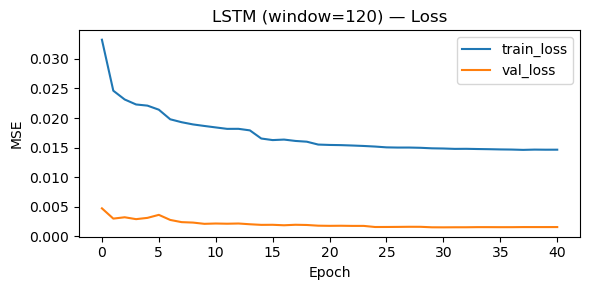

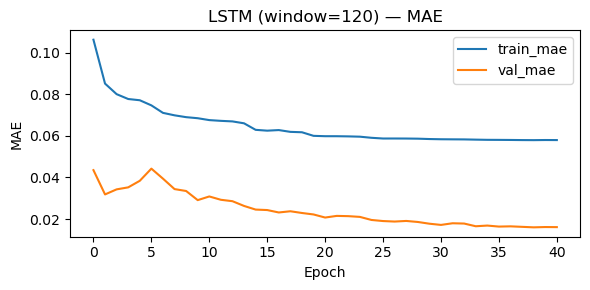

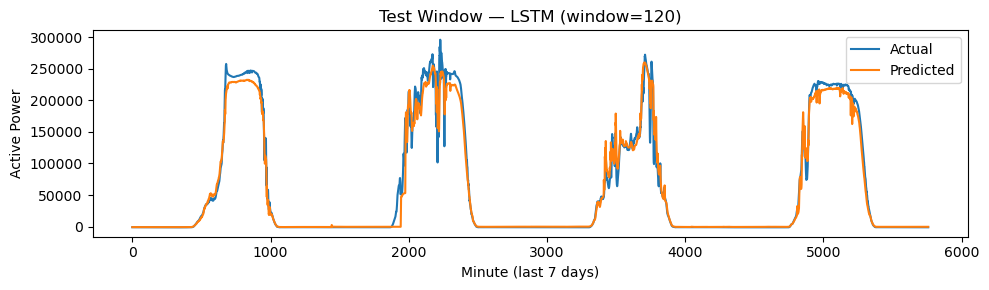

In [ ]:

for W in WINDOW_SIZES:
    Xtr, ytr = make_sequences(X_train, y_train, window=W, horizon=HORIZON)
    Xva, yva = make_sequences(X_val,   y_val,   window=W, horizon=HORIZON)
    Xte, yte = make_sequences(X_test,  y_test,  window=W, horizon=HORIZON)

    model = build_lstm((W, Xtr.shape[-1]))

    es = callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
    rlrop = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)
    

    # visible progress (loss, mae, mape)
    history = model.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es, rlrop],
        shuffle=False,           
    )

    y_pred = model.predict(Xte, verbose=0).ravel()
    mae, rmse, r2, y_true_inv, y_pred_inv = inverse_metrics(yte, y_pred)

    results[W] = {"history": history, "metrics": (mae, rmse, r2), "y_true": y_true_inv, "y_pred": y_pred_inv}

    # ---- Training curves ----
    plt.figure(figsize=(6,3))
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(f"LSTM (window={W}) — Loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,3))
    plt.plot(history.history["mae"], label="train_mae")
    plt.plot(history.history["val_mae"], label="val_mae")
    plt.title(f"LSTM (window={W}) — MAE")
    plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend(); plt.tight_layout(); plt.show()

    # ---- Test visualization ----
    steps = min(len(y_true_inv), 4*24*60)
    plt.figure(figsize=(10,3))
    plt.plot(y_true_inv[-steps:], label="Actual")
    plt.plot(y_pred_inv[-steps:], label="Predicted")
    plt.title(f"Test Window — LSTM (window={W})")
    plt.xlabel("Minute (last 7 days)")
    plt.ylabel("Active Power")
    plt.legend(); plt.tight_layout(); plt.show()

    model.save(f"LSTM_IG{W}.keras")  # save model


In [100]:
# ---- Print summary ----
for W, r in results.items():
    mae, rmse, r2 = r["metrics"]
    print(f"[LSTM window={W}]  MAE: {mae:,.0f}   RMSE: {rmse:,.0f}   R²: {r2:.3f}")

[LSTM window=30]  MAE: 8,678   RMSE: 15,034   R²: 0.979
[LSTM window=60]  MAE: 5,947   RMSE: 13,509   R²: 0.983
[LSTM window=120]  MAE: 5,304   RMSE: 13,390   R²: 0.984


**i'll stuck w 60 window size**  nah never mind 

/opt/anaconda3/envs/solar/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,actual,predicted,error
Time,,,
2020-10-20 21:11:00,-886.149536,-485.672974,400.476562
2020-10-20 21:12:00,-884.688599,-477.977661,406.710938
2020-10-20 21:13:00,-884.219849,-477.751099,406.468750
2020-10-20 21:14:00,-884.008911,-470.407349,413.601562
2020-10-20 21:15:00,-887.219849,-471.274536,415.945312


MAE: 15,690.49 | RMSE: 39,366.48 | R²: 0.857


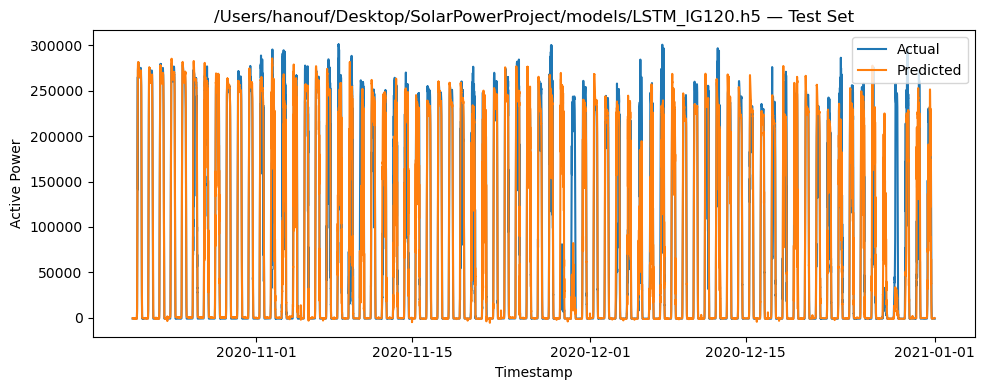

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras

# pick the window/model you want to inspect
WINDOW = 120
MODEL_FILE = f"/Users/hanouf/Desktop/SolarPowerProject/models/LSTM_IG{WINDOW}.h5"  

model = keras.models.load_model(MODEL_FILE,compile=False)

# rebuild the test sequences
Xte, yte = make_sequences(X_test, y_test, window=WINDOW, horizon=HORIZON)
y_pred_sc = model.predict(Xte, verbose=0).ravel()

# bring predictions back to the original scale + compute metrics
mae, rmse, r2, y_true_inv, y_pred_inv = inverse_metrics(yte, y_pred_sc)

# align predictions with their timestamps
len_test = len(X_test)
test_idx = y.index[-len_test:]
aligned_idx = test_idx[WINDOW + HORIZON - 1:]

comparison = (
    pd.DataFrame({"actual": y_true_inv, "predicted": y_pred_inv}, index=aligned_idx)
    .assign(error=lambda df: df["predicted"] - df["actual"])
)

display(comparison.head())
print(f"MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | R²: {r2:.3f}")

plt.figure(figsize=(10,4))
plt.plot(aligned_idx, y_true_inv, label="Actual")
plt.plot(aligned_idx, y_pred_inv, label="Predicted")
plt.title(f"{MODEL_FILE} — Test Set")
plt.xlabel("Timestamp")
plt.ylabel("Active Power")
plt.legend()
plt.tight_layout()
plt.show()


# Stacked LSTM

In [105]:
def build_Stackedlstm(input_shape):
    model = models.Sequential([
        layers.LSTM(128, return_sequences=True, dropout=0.01, recurrent_dropout=0.1),
        layers.LSTM(64, dropout=0.2, recurrent_dropout=0.1),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=optimizers.AdamW(),
        loss="mse",
        metrics=['mae', 'mape'])
    
    return model

Epoch 1/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 228s 148ms/step - loss: 0.0557 - mae: 0.1378 - mape: 82.6651 - val_loss: 0.0032 - val_mae: 0.0311 - val_mape: 10.6397 - learning_rate: 0.0010
Epoch 2/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 297s 200ms/step - loss: 0.0341 - mae: 0.0995 - mape: 71.1566 - val_loss: 0.0038 - val_mae: 0.0356 - val_mape: 9.7871 - learning_rate: 0.0010
Epoch 3/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 322s 217ms/step - loss: 0.0304 - mae: 0.0886 - mape: 68.6415 - val_loss: 0.0040 - val_mae: 0.0361 - val_mape: 8.1004 - learning_rate: 0.0010
Epoch 4/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 283s 191ms/step - loss: 0.0283 - mae: 0.0840 - mape: 68.5122 - val_loss: 0.0041 - val_mae: 0.0372 - val_mape: 8.3320 - learning_rate: 0.0010
Epoch 5/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0274 - mae: 0.0793 - mape: 63.1559
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 327s 221ms/step - loss: 0.0274 - mae: 0.0793 - mape: 63.141

/opt/anaconda3/envs/solar/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


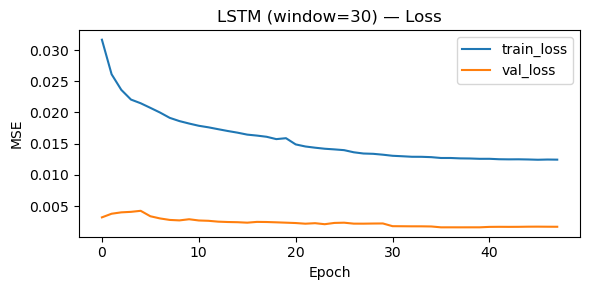

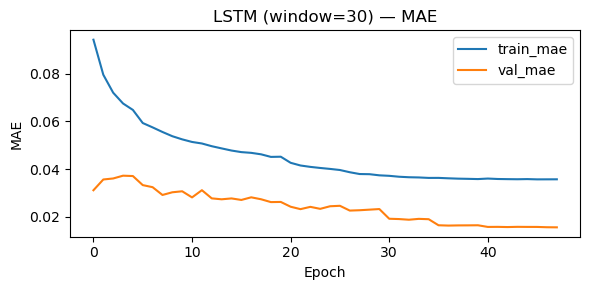

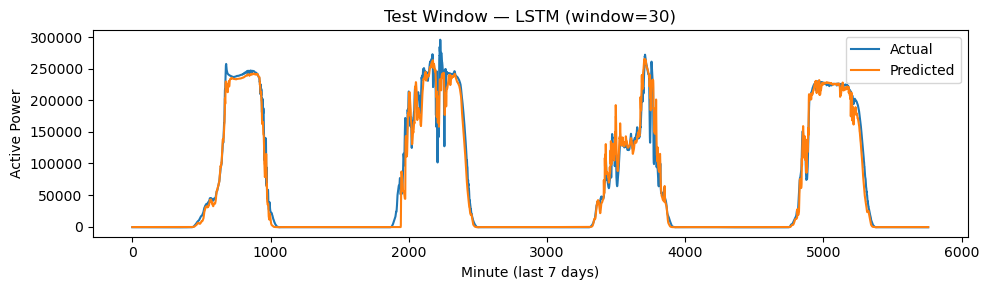

Epoch 1/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 581s 388ms/step - loss: 0.0511 - mae: 0.1346 - mape: 79.3322 - val_loss: 0.0037 - val_mae: 0.0375 - val_mape: 9.9055 - learning_rate: 0.0010
Epoch 2/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 586s 395ms/step - loss: 0.0325 - mae: 0.0982 - mape: 74.1771 - val_loss: 0.0051 - val_mae: 0.0409 - val_mape: 9.3433 - learning_rate: 0.0010
Epoch 3/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 584s 394ms/step - loss: 0.0296 - mae: 0.0867 - mape: 67.0346 - val_loss: 0.0044 - val_mae: 0.0384 - val_mape: 7.9128 - learning_rate: 0.0010
Epoch 4/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 585s 394ms/step - loss: 0.0291 - mae: 0.0857 - mape: 66.0127 - val_loss: 0.0049 - val_mae: 0.0414 - val_mape: 8.7798 - learning_rate: 0.0010
Epoch 5/50
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - loss: 0.0285 - mae: 0.0801 - mape: 61.7485
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 605s 408ms/step - loss: 0.0285 - mae: 0.0801 - mape: 61.7344

/opt/anaconda3/envs/solar/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


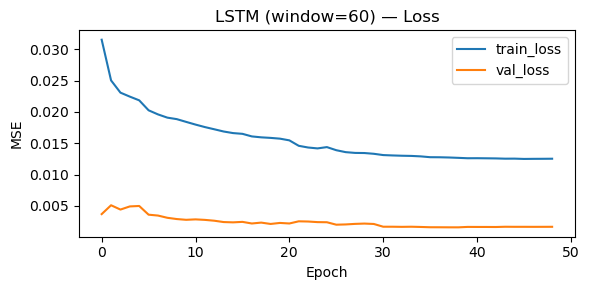

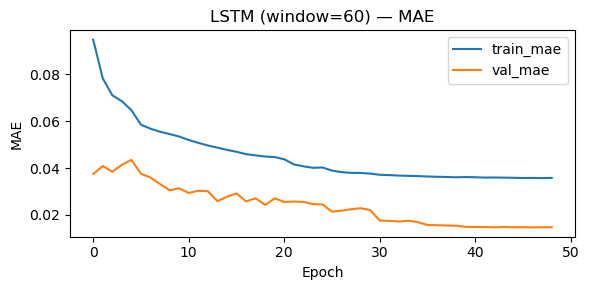

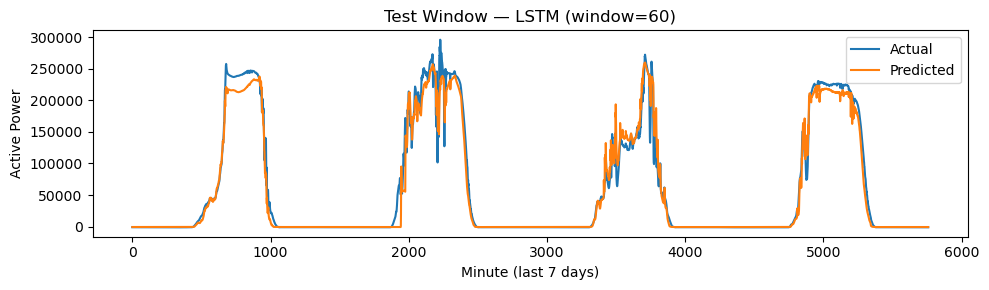

Epoch 1/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 1150s 771ms/step - loss: 0.0575 - mae: 0.1385 - mape: 81.9662 - val_loss: 0.0044 - val_mae: 0.0396 - val_mape: 12.4303 - learning_rate: 0.0010
Epoch 2/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 1117s 754ms/step - loss: 0.0315 - mae: 0.0956 - mape: 69.4135 - val_loss: 0.0042 - val_mae: 0.0406 - val_mape: 9.5361 - learning_rate: 0.0010
Epoch 3/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 1077s 727ms/step - loss: 0.0291 - mae: 0.0881 - mape: 73.4487 - val_loss: 0.0037 - val_mae: 0.0361 - val_mape: 10.0837 - learning_rate: 0.0010
Epoch 4/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 1076s 726ms/step - loss: 0.0289 - mae: 0.0839 - mape: 62.9919 - val_loss: 0.0046 - val_mae: 0.0383 - val_mape: 9.3116 - learning_rate: 0.0010
Epoch 5/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 1081s 729ms/step - loss: 0.0282 - mae: 0.0807 - mape: 65.2328 - val_loss: 0.0053 - val_mae: 0.0426 - val_mape: 9.5067 - learning_rate: 0.0010
Epoch 6/50
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 1087s 734ms/step - loss: 0.0273 - ma

/opt/anaconda3/envs/solar/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


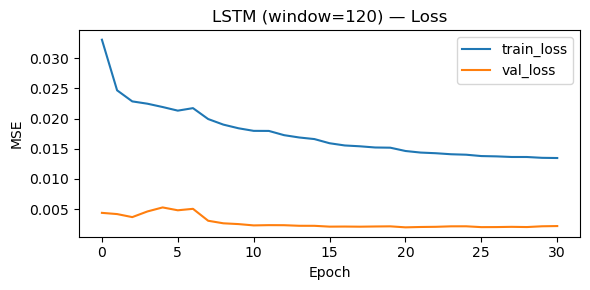

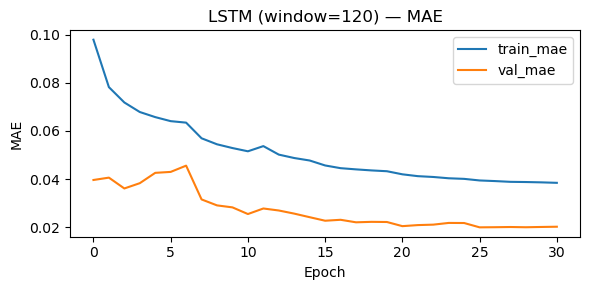

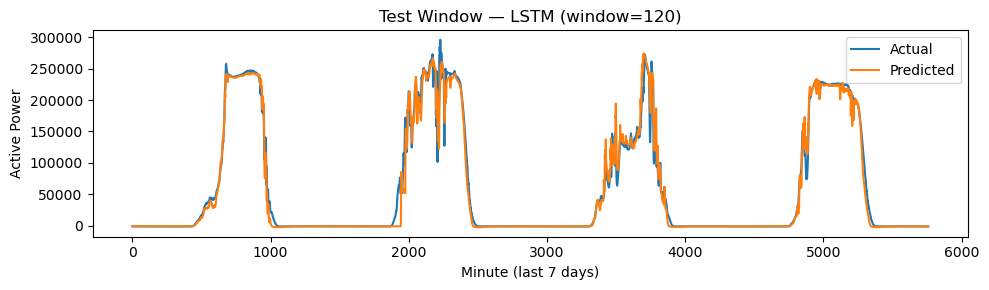

In [ ]:

for W in WINDOW_SIZES:
    Xtr, ytr = make_sequences(X_train, y_train, window=W, horizon=HORIZON)
    Xva, yva = make_sequences(X_val,   y_val,   window=W, horizon=HORIZON)
    Xte, yte = make_sequences(X_test,  y_test,  window=W, horizon=HORIZON)

    model = build_Stackedlstm((W, Xtr.shape[-1]))

    es = callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
    rlrop = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)
    

    # visible progress (loss, mae, mape)
    history = model.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es, rlrop],
        shuffle=False,           
    )

    y_pred = model.predict(Xte, verbose=0).ravel()
    mae, rmse, r2, y_true_inv, y_pred_inv = inverse_metrics(yte, y_pred)

    results[W] = {"history": history, "metrics": (mae, rmse, r2), "y_true": y_true_inv, "y_pred": y_pred_inv}

    # ---- Training curves ----
    plt.figure(figsize=(6,3))
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(f"LSTM (window={W}) — Loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,3))
    plt.plot(history.history["mae"], label="train_mae")
    plt.plot(history.history["val_mae"], label="val_mae")
    plt.title(f"LSTM (window={W}) — MAE")
    plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend(); plt.tight_layout(); plt.show()

    # ---- Test visualization ----
    steps = min(len(y_true_inv), 4*24*60)
    plt.figure(figsize=(10,3))
    plt.plot(y_true_inv[-steps:], label="Actual")
    plt.plot(y_pred_inv[-steps:], label="Predicted")
    plt.title(f"Test Window — LSTM (window={W})")
    plt.xlabel("Minute (last 7 days)")
    plt.ylabel("Active Power")
    plt.legend(); plt.tight_layout(); plt.show()

    model.save(f"StackedLSTM_IG{W}.h5")



In [107]:
# ---- Print summary ----
for W, r in results.items():
    mae, rmse, r2 = r["metrics"]
    print(f"[LSTM window={W}]  MAE: {mae:,.0f}   RMSE: {rmse:,.0f}   R²: {r2:.3f}")

[LSTM window=30]  MAE: 5,079   RMSE: 13,604   R²: 0.983
[LSTM window=60]  MAE: 5,035   RMSE: 13,190   R²: 0.984
[LSTM window=120]  MAE: 5,007   RMSE: 13,361   R²: 0.984


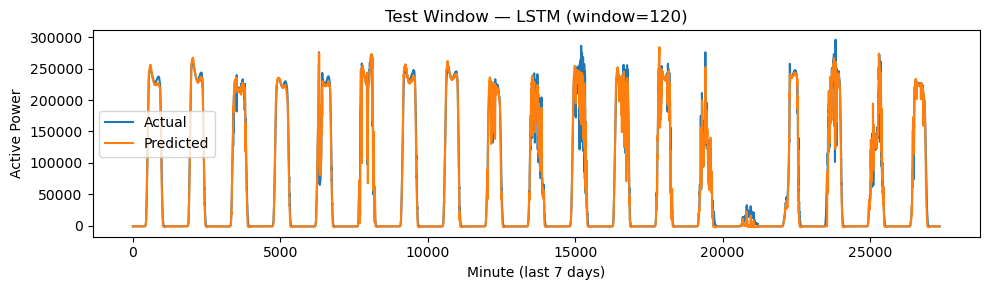

In [111]:
# ---- Test visualization ----
steps = min(len(y_true_inv), 19*24*60)
plt.figure(figsize=(10,3))
plt.plot(y_true_inv[-steps:], label="Actual")
plt.plot(y_pred_inv[-steps:], label="Predicted")
plt.title(f"Test Window — LSTM (window={W})")
plt.xlabel("Minute (last 7 days)")
plt.ylabel("Active Power")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
model.save(f"StackedLSTM_IG{W}.keras")

/var/folders/fc/3f5dtyyn2m589pf7gzyk878m0000gn/T/ipykernel_6027/3001420646.py:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y_hourly = y_future.resample("1H").mean()


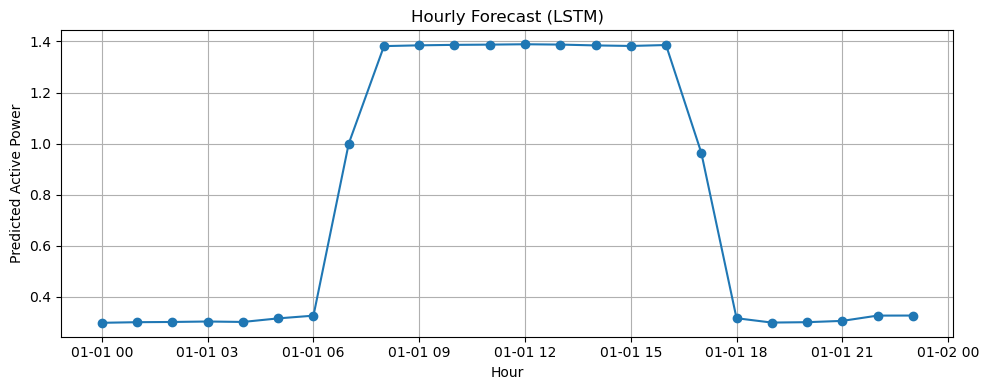

In [113]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

FEATS   = features_ig            # columns used to train the LSTM
TARGET  = "active_power"         # change if needed
WINDOW  = model.input_shape[1]   # timesteps
HORIZON = 24 * 60                # 1 day @ 1-min
FREQ    = "1min"

# future timeline
last_ts = df_main.index[-1]
future_idx = pd.date_range(last_ts + pd.Timedelta(minutes=1), periods=HORIZON, freq=FREQ)

# seed window (last WINDOW rows of features)
ctx = df_main[FEATS].iloc[-WINDOW:].copy()

# make a simple repeating exogenous plan from last day (if you have exo)
one_day = 1440
exo = df_main[FEATS].iloc[-one_day:].copy()
exo = pd.concat([exo]*int(np.ceil(HORIZON/one_day)), axis=0).iloc[:HORIZON]
exo.index = future_idx

preds = []
for ts in future_idx:
    x = ctx.values.reshape(1, WINDOW, len(FEATS))
    yhat = float(model.predict(x, verbose=0).squeeze())
    preds.append(yhat)

    # prepare next feature row
    next_row = exo.loc[ts].copy()
    if TARGET in FEATS:
        next_row[TARGET] = yhat
    ctx = pd.concat([ctx, pd.DataFrame([next_row], index=[ts])]).iloc[-WINDOW:]

y_future = pd.Series(preds, index=future_idx, name=f"{TARGET}_pred")
y_hourly = y_future.resample("1H").mean()

plt.figure(figsize=(10,4))
plt.plot(y_hourly.index, y_hourly.values, marker="o")
plt.title("Hourly Forecast (LSTM)")
plt.xlabel("Hour"); plt.ylabel("Predicted Active Power"); plt.grid(True); plt.tight_layout()
plt.show()


# Bidirectional LSTM

In [114]:
def build_Bidirectionalstm(input_shape):
    model = models.Sequential([
        layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)),
        layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.1)),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=optimizers.AdamW(),
        loss="mse",
        metrics=['mae', 'mape'])
    
    return model

Epoch 1/50
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 772s 510ms/step - loss: 0.1632 - mae: 0.2539 - mape: 138.1480 - val_loss: 0.0111 - val_mae: 0.0756 - val_mape: 27.7654 - learning_rate: 0.0010
Epoch 2/50
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 632s 428ms/step - loss: 0.1296 - mae: 0.1998 - mape: 141.3205 - val_loss: 0.0101 - val_mae: 0.0657 - val_mape: 22.1211 - learning_rate: 0.0010
Epoch 3/50
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 553s 374ms/step - loss: 0.1230 - mae: 0.1867 - mape: 140.2444 - val_loss: 0.0096 - val_mae: 0.0664 - val_mape: 18.8268 - learning_rate: 0.0010
Epoch 4/50
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 551s 373ms/step - loss: 0.1195 - mae: 0.1802 - mape: 135.1040 - val_loss: 0.0095 - val_mae: 0.0661 - val_mape: 14.1909 - learning_rate: 0.0010
Epoch 5/50
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 555s 376ms/step - loss: 0.1162 - mae: 0.1754 - mape: 132.1297 - val_loss: 0.0106 - val_mae: 0.0642 - val_mape: 12.3768 - learning_rate: 0.0010
Epoch 6/50
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 490s 331ms/step - loss: 0.1126 - 

/opt/anaconda3/envs/solar/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


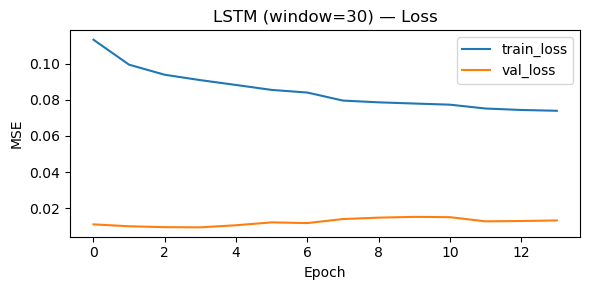

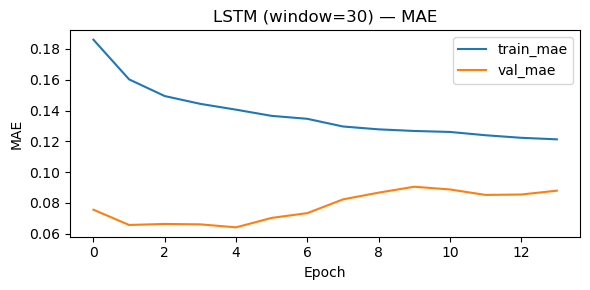

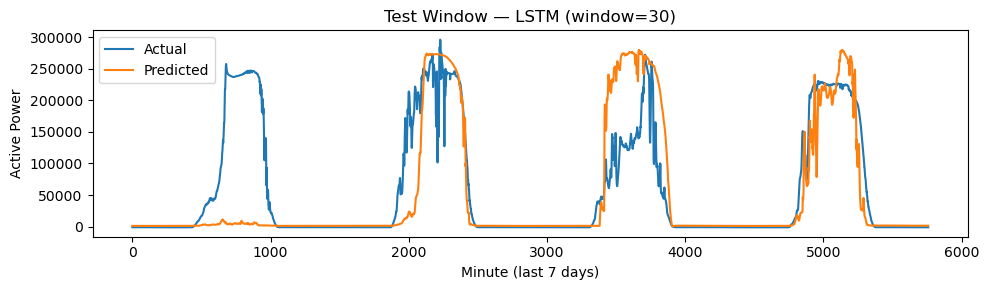

Epoch 1/50
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 1121s 749ms/step - loss: 0.1815 - mae: 0.2678 - mape: 143.5528 - val_loss: 0.0109 - val_mae: 0.0698 - val_mape: 28.0810 - learning_rate: 0.0010
Epoch 2/50
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 1112s 753ms/step - loss: 0.1323 - mae: 0.2033 - mape: 142.5521 - val_loss: 0.0098 - val_mae: 0.0676 - val_mape: 21.5338 - learning_rate: 0.0010
Epoch 3/50
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 1109s 751ms/step - loss: 0.1256 - mae: 0.1910 - mape: 133.3809 - val_loss: 0.0103 - val_mae: 0.0669 - val_mape: 20.6322 - learning_rate: 0.0010
Epoch 4/50
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 1104s 747ms/step - loss: 0.1214 - mae: 0.1840 - mape: 138.0684 - val_loss: 0.0104 - val_mae: 0.0647 - val_mape: 14.5038 - learning_rate: 0.0010
Epoch 5/50
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 1086s 735ms/step - loss: 0.1182 - mae: 0.1780 - mape: 139.2676 - val_loss: 0.0146 - val_mae: 0.1023 - val_mape: 15.1742 - learning_rate: 0.0010
Epoch 6/50
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - loss: 0.1146

KeyboardInterrupt: 

In [ ]:

for W in WINDOW_SIZES:
    Xtr, ytr = make_sequences(X_train, y_train, window=W, horizon=HORIZON)
    Xva, yva = make_sequences(X_val,   y_val,   window=W, horizon=HORIZON)
    Xte, yte = make_sequences(X_test,  y_test,  window=W, horizon=HORIZON)

    model = build_Bidirectionalstm((W, Xtr.shape[-1]))

    es = callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
    rlrop = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)
    

    # visible progress (loss, mae, mape)
    history = model.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es, rlrop],
        shuffle=False,           
    )

    y_pred = model.predict(Xte, verbose=0).ravel()
    mae, rmse, r2, y_true_inv, y_pred_inv = inverse_metrics(yte, y_pred)

    results[W] = {"history": history, "metrics": (mae, rmse, r2), "y_true": y_true_inv, "y_pred": y_pred_inv}

    # ---- Training curves ----
    plt.figure(figsize=(6,3))
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(f"LSTM (window={W}) — Loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,3))
    plt.plot(history.history["mae"], label="train_mae")
    plt.plot(history.history["val_mae"], label="val_mae")
    plt.title(f"LSTM (window={W}) — MAE")
    plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend(); plt.tight_layout(); plt.show()

    # ---- Test visualization ----
    steps = min(len(y_true_inv), 4*24*60)
    plt.figure(figsize=(10,3))
    plt.plot(y_true_inv[-steps:], label="Actual")
    plt.plot(y_pred_inv[-steps:], label="Predicted")
    plt.title(f"Test Window — LSTM (window={W})")
    plt.xlabel("Minute (last 7 days)")
    plt.ylabel("Active Power")
    plt.legend(); plt.tight_layout(); plt.show()

    model.save(f"BI_LSTM_IG{W}.keras")



# CNN → LSTM

In [117]:
def build_CNNlstm(input_shape):
    model = models.Sequential([
        layers.Conv1D(64, 3, padding="causal", activation="relu"),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 3, padding="causal", activation="relu"),
        layers.LSTM(64, dropout=0.2, recurrent_dropout=0.1),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=optimizers.AdamW(),
        loss="mse",
        metrics=['mae', 'mape'])
    
    return model

Epoch 1/50
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 98s 61ms/step - loss: 0.1572 - mae: 0.2382 - mape: 141.2541 - val_loss: 0.0158 - val_mae: 0.0887 - val_mape: 22.5527 - learning_rate: 0.0010
Epoch 2/50
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 91s 61ms/step - loss: 0.1245 - mae: 0.1897 - mape: 139.7902 - val_loss: 0.0137 - val_mae: 0.0800 - val_mape: 18.0559 - learning_rate: 0.0010
Epoch 3/50
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 86s 58ms/step - loss: 0.1178 - mae: 0.1807 - mape: 138.0218 - val_loss: 0.0156 - val_mae: 0.0843 - val_mape: 15.4776 - learning_rate: 0.0010
Epoch 4/50
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 82s 56ms/step - loss: 0.1128 - mae: 0.1742 - mape: 134.7807 - val_loss: 0.0184 - val_mae: 0.0952 - val_mape: 17.4620 - learning_rate: 0.0010
Epoch 5/50
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 76s 52ms/step - loss: 0.1092 - mae: 0.1685 - mape: 129.1751 - val_loss: 0.0192 - val_mae: 0.0972 - val_mape: 23.2581 - learning_rate: 0.0010
Epoch 6/50
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1066 - mae: 0.1648 -

/opt/anaconda3/envs/solar/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


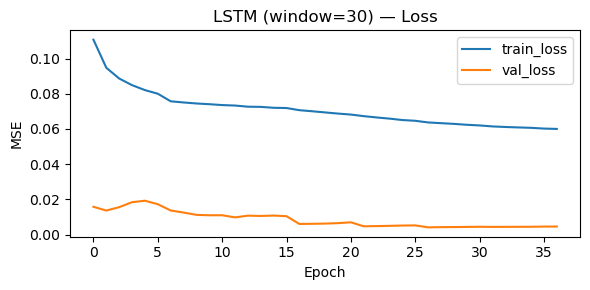

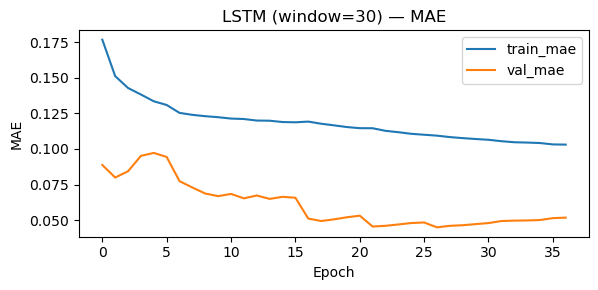

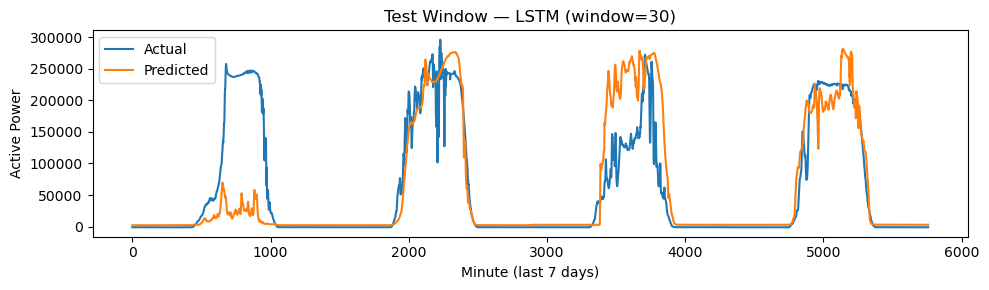

Epoch 1/50
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 130s 83ms/step - loss: 0.1610 - mae: 0.2400 - mape: 147.4954 - val_loss: 0.0144 - val_mae: 0.0873 - val_mape: 23.9579 - learning_rate: 0.0010
Epoch 2/50
 211/1477 ━━━━━━━━━━━━━━━━━━━━ 1:55 91ms/step - loss: 0.1056 - mae: 0.1871 - mape: 182.7303

KeyboardInterrupt: 

In [ ]:

for W in WINDOW_SIZES:
    Xtr, ytr = make_sequences(X_train, y_train, window=W, horizon=HORIZON)
    Xva, yva = make_sequences(X_val,   y_val,   window=W, horizon=HORIZON)
    Xte, yte = make_sequences(X_test,  y_test,  window=W, horizon=HORIZON)

    model = build_CNNlstm((W, Xtr.shape[-1]))

    es = callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
    rlrop = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)
    

    # visible progress (loss, mae, mape)
    history = model.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es, rlrop],
        shuffle=False,           
    )

    y_pred = model.predict(Xte, verbose=0).ravel()
    mae, rmse, r2, y_true_inv, y_pred_inv = inverse_metrics(yte, y_pred)

    results[W] = {"history": history, "metrics": (mae, rmse, r2), "y_true": y_true_inv, "y_pred": y_pred_inv}

    # ---- Training curves ----
    plt.figure(figsize=(6,3))
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(f"LSTM (window={W}) — Loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,3))
    plt.plot(history.history["mae"], label="train_mae")
    plt.plot(history.history["val_mae"], label="val_mae")
    plt.title(f"LSTM (window={W}) — MAE")
    plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend(); plt.tight_layout(); plt.show()

    # ---- Test visualization ----
    steps = min(len(y_true_inv), 4*24*60)
    plt.figure(figsize=(10,3))
    plt.plot(y_true_inv[-steps:], label="Actual")
    plt.plot(y_pred_inv[-steps:], label="Predicted")
    plt.title(f"Test Window — LSTM (window={W})")
    plt.xlabel("Minute (last 7 days)")
    plt.ylabel("Active Power")
    plt.legend(); plt.tight_layout(); plt.show()

    model.save(f"CNN_LSTM_IG{W}.keras")

